# Kronos Training Loop

This model comes transfering codes from Kronos_sina to fucntions.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale

from pullDate_FullPeriod import pull_data , pull_seas 


# Python local connection to Oracle (herccrt) and Teradata (mosaic)
def connect_to_servers():
    from config import herccrt, mosaic, azure
    hcrt = herccrt().con()
    mos = mosaic().con()
    az = azure().con()
    return hcrt, mos, az

# jupyter notebook settings
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20) # DON't Use None, it will show every row --> resulting in CRASH

hcrt, mos, az = connect_to_servers()

In [2]:
# choose directional market leg
orig = 'PHX'
dest = 'DFW'
### HAS UCLL:
# orig = 'DEN'
# dest = 'DFW'

new_market = False # change this to True if it is a new market

# choose fcst_id
fcst_id = 1


# constants
cabin = 'Y'
ulcc_list = ['NK','SY','F9'] # Spirit SunCountry Frontier 


# pull data time range
# pull_start = '2015-09-01'
# pull_end = '2023-12-30'

next_year_today = datetime.today() + timedelta(days=365)
yesterday =  datetime.today() - timedelta(days=1)

pull_start = '2017-09-01'
# pull_end = next_year_today.strftime("%Y-%m-%d")
pull_end = yesterday.strftime("%Y-%m-%d")

# Pre: pre-covid period, used for train and validation
Pre_start, Pre_end = '2017-09-01', '2020-01-30'
# Post: post-covid period, used for test
# Post_start, Post_end = '2021-07-01', '2022-06-30'
Post_start, Post_end = '2021-07-01', pull_end


# # !!! update here if use another fcst_id - NOT Sure what is this!
# fcst_start = 988
# fcst_end = 1619

In [3]:

def find_all_dest_given_leg(orig, hcrt):
    # Find cities given one leg:

    
    fcst_id_qry = f"""
    select Distinct LEG_DEST_S as dest
    from fcst.fcst_id_ref
    where LEG_ORIG_S = '{orig}'
    """
    fcst_id_df = pd.read_sql_query(fcst_id_qry, con=hcrt)

    return list(value[0] for value in fcst_id_df.values)


def get_fcst_given_leg(orig, dest, hcrt ):
    # Find fcst_id and start and end of the fcst time_bounds for a given orig dest

    fcst_id_qry = f"""
    select Distinct LEG_ORIG_S as orig, LEG_DEST_S as dest, FCST_ID as fcst_id,
            TIME_BAND_START as time_band_start, TIME_BAND_END as time_band_end
    from fcst.fcst_id_ref
    where 1=1 
    and LEG_ORIG_S = '{orig}'
    and LEG_DEST_S = '{dest}'
    order by 1,2,3,4
    """
    fcst_id_df = pd.read_sql_query(fcst_id_qry, con=hcrt)
   

    return fcst_id_df



In [4]:
def get_oag_data(orig,dest, pull_start, pull_end):

    oag_qry = f"""
    select DEP_AIRPRT_IATA_CD as orig, 
            ARVL_AIRPRT_IATA_CD as dest,
            LOCAL_DEP_DT as dep_date, 
            DEP_MINUTE_PAST_MDNGHT_QTY as dep_mam,
            FLIGHT_SCHD_PUBLSH_DT as snapshot_date,
            OPERAT_AIRLN_IATA_CD as airline, 
            OPERAT_FLIGHT_NBR as flt_id, -- Flight Number 
            EQUIP_COACH_CABIN_SEAT_QTY as seats, 
            ASMS_QTY as asm,
            EQUIP_COACH_CABIN_SEAT_QTY * MILE_GREAT_CIRCLE_DISTANC_QTY as asm_y -- ASM for Coach Cabin
    from PROD_INDSTR_FLIGHT_SCHD_VW.OAG_CURR  
    where 1=1
    and DEP_AIRPRT_IATA_CD = '{orig}'
    and ARVL_AIRPRT_IATA_CD = '{dest}' 
    and LOCAL_DEP_DT between '{pull_start}' and '{pull_end}'
    -- and LOCAL_DEP_DT = '2022-09-12'
    -- and OPERAT_AIRLN_IATA_CD = 'AA'
    and OPERAT_PAX_FLIGHT_IND = 'Y' -- new field that determines if record is a scheduled operating flight record
    and FLIGHT_OAG_PUBLSH_CD <> 'X' -- record is active and not cancelled 
    order by 1,2,3,4,5
    """

    oag_df = pd.read_sql(oag_qry, con=mos)


    # convert to datetime format
    oag_df['dep_date'] = pd.to_datetime(oag_df['dep_date'], format='%Y/%m/%d')

    # convert the dep_time before 3am to the previous dep_date
    # + Also you have ti change the dep_date for that one as well.
    oag_df['dep_mins'] = [val+24*60 if val<180 else val for val in oag_df['dep_mam']]
    oag_df['adj_dep_date'] = [date - dt.timedelta(days=1) if mam<180 else date for mam, date in zip(oag_df['dep_mam'],oag_df['dep_date'])]

    # add yr, mo, wk cols
    oag_df['yr'] = oag_df['adj_dep_date'].dt.year
    oag_df['mo'] = oag_df['adj_dep_date'].dt.month
    oag_df['wk'] = oag_df['adj_dep_date'].dt.isocalendar().week
    # add ulcc indicator
    oag_df['ulcc_ind'] = [1 if val in ulcc_list else 0 for val in oag_df['airline']]
    oag_df['seats_ulcc'] = [seats if val in ulcc_list else 0 for val , seats in zip(oag_df['airline'],oag_df['seats'])]


    return oag_df


def get_cap_data(orig,dest, pull_start, pull_end , cabin = 'Y'):
    cap_query = f"""
    select LEG_DEP_AIRPRT_IATA_CD as orig, 
            LEG_ARVL_AIRPRT_IATA_CD as dest,
            SCHD_LEG_DEP_DT as dep_date, 
            SCHD_LEG_DEP_TM as dep_time, 
            FILE_SNPSHT_DT as snapshot_date,
            LEG_CABIN_CD as cabin, 
            OPERAT_AIRLN_IATA_CD as airline, 
            MKT_FLIGHT_NBR as flt_id,  --Flight Number
            CABIN_CAPCTY_SEAT_QTY as seats, 
            CAB_ASM_QTY as asm, 
            CAB_TOT_RPM_QTY as rpm,
            CAB_TOT_REVNUE_AMT as rev, 
            CAB_TOT_PAX_QTY as pax
    from PROD_RM_BUSINES_VW.LIFE_OF_FLIGHT_LEG_CABIN 
    where 1=1
    and FILE_SNPSHT_DT = SCHD_LEG_DEP_DT-1 -- only extract the data one day before departure
    and LEG_DEP_AIRPRT_IATA_CD = '{orig}'
    and LEG_ARVL_AIRPRT_IATA_CD = '{dest}'
    and SCHD_LEG_DEP_DT between '{pull_start}' and '{pull_end}'
    -- and SCHD_LEG_DEP_DT = '2022-09-12' 
    and LEG_CABIN_CD = '{cabin}'
    order by 1,2,3,4,5
    """

    cap_df = pd.read_sql(cap_query, con=mos)


    # convert to datetime format
    cap_df['dep_date'] = pd.to_datetime(cap_df['dep_date'], format='%Y/%m/%d')
    # cap_df['dep_time'] = pd.to_datetime(cap_df['dep_date']+cap_df['dep_time'], format='%H:%M:%S')
    cap_df['dep_time'] = pd.to_datetime(cap_df['dep_date'].astype(str)+' '+cap_df['dep_time'].astype(str), format='%Y/%m/%d %H:%M:%S')

    # count the minutes from mid-night
    cap_df['dep_mins'] = pd.DatetimeIndex(cap_df['dep_time']).hour*60 + pd.DatetimeIndex(cap_df['dep_time']).minute
    # convert the dep_time before 3am to the previous dep_date
    # + Also you have to adjust the dep_date for that one as well.
    cap_df['adj_dep_date'] = [date - dt.timedelta(days=1) if mam<180 else date for mam, date in zip(cap_df['dep_mins'],cap_df['dep_date'])]
    cap_df['dep_mins'] = [val+24*60 if val<180 else val for val in cap_df['dep_mins']]


    # add yr, mo, wk
    cap_df['yr'] = cap_df['adj_dep_date'].dt.year
    cap_df['mo'] = cap_df['adj_dep_date'].dt.month
    cap_df['wk'] = cap_df['adj_dep_date'].dt.isocalendar().week

    return cap_df

In [5]:
def oag_per_day(oag_df):
    # get OA Cap per day.

    # groupby for the entire market (So we can calculate the Shares) - Sina changed it to per day.
    gp_cols = ['adj_dep_date','airline'] 
    agg_cols = {'seats':'sum', 'asm_y':'sum','flt_id':'count','ulcc_ind':'sum', 'seats_ulcc': 'sum'}

    oag_kl_Per_airline_Day = oag_df.groupby(gp_cols).agg(agg_cols).reset_index()

    # change flt_id name as flt_ct, and asm_y to asm (since we are focusing on y cabin)
    oag_kl_Per_airline_Day.rename(columns={'flt_id':'flt_ct','ulcc_ind':'ulcc_ind_mkt', 'asm_y':'asm' }, inplace=True) 

    # Now lets aggrigate all airlines to have infomration on all airlines.
    gp_cols = ['adj_dep_date'] 
    agg_cols = {'seats':'sum', 'asm':'sum','flt_ct':'sum','ulcc_ind_mkt':'sum', 'seats_ulcc': 'sum'}

    oag_kl_total_Per_Day = oag_kl_Per_airline_Day.groupby(gp_cols).agg(agg_cols).reset_index()

    # Filter American flights into a seperate view

    filter0 = oag_kl_Per_airline_Day['airline'] == 'AA'
    oag_kl_Per_american_Day = oag_kl_Per_airline_Day[filter0]

    # Drop unrelated infomration
    oag_kl_Per_american_Day.drop(columns=['ulcc_ind_mkt','seats_ulcc','airline'],inplace=True)

    # Merge the AA data with the aggrigate data 
    oag_kl_total_Per_Day_and_AA = pd.merge(oag_kl_total_Per_Day,oag_kl_Per_american_Day,on = gp_cols, how='left',suffixes=('_All', '_AA'))
    oag_kl_total_Per_Day_and_AA.rename(columns={'ulcc_ind_mkt':'flt_ct_ulcc'}, inplace=True) 

    # Calculate OA data.
    oag_kl_total_Per_Day_and_AA['seats_OA'] = oag_kl_total_Per_Day_and_AA['seats_All'] - oag_kl_total_Per_Day_and_AA['seats_AA'] -  oag_kl_total_Per_Day_and_AA['seats_ulcc'] 
    oag_kl_total_Per_Day_and_AA['flt_ct_OA'] = oag_kl_total_Per_Day_and_AA['flt_ct_All'] - oag_kl_total_Per_Day_and_AA['flt_ct_AA'] - oag_kl_total_Per_Day_and_AA['flt_ct_ulcc']

    # Reformat the data
    oag_kl_total_Per_Day_and_AA = oag_kl_total_Per_Day_and_AA.loc[:,['adj_dep_date','seats_AA','seats_OA','seats_ulcc','seats_All','flt_ct_AA' , 'flt_ct_OA' ,'flt_ct_ulcc' , 'flt_ct_All' ,'asm_AA','asm_All']]

    return oag_kl_total_Per_Day_and_AA


def oag_per_fcst(oag_df, fcst_start, fcst_end ):
    # OAG only keep the dep_mins in the fcst_id
    oag_df2 = oag_df[(oag_df['dep_mins']>=fcst_start) & (oag_df['dep_mins']<=fcst_end)]


    # here we only care about AA.
    gp_cols = ['adj_dep_date','airline']
    agg_cols = {'seats':'sum', 'asm_y':'sum','flt_id':'count','ulcc_ind':'sum', 'seats_ulcc': 'sum' }

    oag_kl = oag_df2.groupby(gp_cols).agg(agg_cols).reset_index()
    # change flt_id name as flt_ct
    oag_kl.rename(columns={'flt_id':'flt_ct', 'asm_y':'asm'}, inplace=True)
    oag_kl
    # groupby for the entire market (So we can calculate the Shares) 
    gp_cols = ['adj_dep_date'] 
    agg_cols = {'seats':'sum','asm_y':'sum' ,'flt_id':'count','ulcc_ind':'sum', 'seats_ulcc': 'sum'}

    oag_kl_AAOA = oag_df2.groupby(gp_cols).agg(agg_cols).reset_index()
    # change flt_id name as flt_ct
    oag_kl_AAOA.rename(columns={'flt_id':'flt_ct' , 'ulcc_ind':'ulcc_count', 'asm_y':'asm' }, inplace=True) 


    # Filter the oag_df2 to show theAA Cap (per fcst span) and merge AAOA Cap (on the specific fcst).
    filterAA = oag_kl['airline'] == 'AA'
    oag_kl = oag_kl[filterAA]
    oag_kl.drop(columns=['ulcc_ind','seats_ulcc','airline'],inplace=True)


    oag_kl = pd.merge(oag_kl,oag_kl_AAOA,on = gp_cols, how='left',suffixes=('_AA_fcst', '_All_fcst'))


    # add OA Cap
    oag_kl['seats_OA_fcst'] = oag_kl['seats_All_fcst']-oag_kl['seats_AA_fcst']-oag_kl['seats_ulcc']
    oag_kl['asm_OA_fcst'] = oag_kl['asm_All_fcst']-oag_kl['asm_AA_fcst']
    oag_kl['flt_ct_OA_fcst'] = oag_kl['flt_ct_All_fcst']-oag_kl['flt_ct_AA_fcst']-oag_kl['ulcc_count']

    # # add AA market share
    # oag_kl['seats_share'] = oag_kl['seats_AA_fcst']/oag_kl['seats_AAOA']
    # oag_kl['asm_share'] = oag_kl['asm_AA_fcst']/oag_kl['asm_AAOA']
    # oag_kl['flt_ct_share'] = oag_kl['flt_ct_AA_fcst']/oag_kl['flt_ct_AAOA']
    # # add seats_per_flt
    # oag_kl['seats_per_flt_AA'] = oag_kl['seats_AA']/oag_kl['flt_ct_AA']
    # oag_kl['seats_per_flt_OA'] = oag_kl['seats_OA']/oag_kl['flt_ct_OA']
    # oag_kl['seats_per_flt_AAOA'] = oag_kl['seats_AAOA']/oag_kl['flt_ct_AAOA']

    oag_kl['fcst_start'] = fcst_start
    oag_kl['fcst_end'] = fcst_end
    oag_kl.rename(columns={'seats_ulcc':'seats_ulcc_fcst' , 'ulcc_count':'flt_ct_ulcc_fcst' }, inplace=True) 

    oag_kl = oag_kl.loc[:,['adj_dep_date', 'fcst_start', 'fcst_end','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst','seats_All_fcst','flt_ct_AA_fcst' , 'flt_ct_OA_fcst' ,'flt_ct_ulcc_fcst' , 'flt_ct_All_fcst' ,'asm_AA_fcst','asm_All_fcst']]

    return oag_kl

def normalize_oag_kl_fcst_total(oag_kl_fcst_total): 
    
    # Drop Null
    oag_kl_fcst_total.dropna(inplace=True)

    # # remove the 
    # oag_kl_fcst_total.drop(columns=['seats','asm','flt_ct' , 'fcst_start' , 'fcst_end'],inplace=True)

    # Normalize Cap features
    norm_cols = [
        'seats_AA_fcst',
        'seats_OA_fcst', 'seats_ulcc_fcst', 'seats_All_fcst', 'flt_ct_AA_fcst',
        'flt_ct_OA_fcst', 'flt_ct_ulcc_fcst', 'flt_ct_All_fcst', 'asm_AA_fcst',
        'asm_All_fcst', 'seats_AA', 'seats_OA', 'seats_ulcc', 'seats_All',
        'flt_ct_AA', 'flt_ct_OA', 'flt_ct_ulcc', 'flt_ct_All', 'asm_AA',
        'asm_All']

    oag_kl_fcst_total[norm_cols] = minmax_scale(oag_kl_fcst_total[norm_cols])
    
    return oag_kl_fcst_total


def aa_cap_fcst(cap_df,fcst_start, fcst_end ):
    # AA Cap only keep the dep_mins in the fcst_id
    cap_df2 = cap_df[(cap_df['dep_mins']>=fcst_start) & (cap_df['dep_mins']<=fcst_end)]

    # get AA Cap
    gp_cols = ['dep_date']   
    agg_cols = {'seats':'sum','asm':'sum','flt_id':'count','rpm':'sum','rev':'sum','pax':'sum'}

    cap_kl = cap_df2.groupby(gp_cols).agg(agg_cols).reset_index()
    cap_kl.rename(columns={'flt_id':'flt_ct'}, inplace=True)

    # add other Cap features
    cap_kl['rasm'] = cap_kl['rev']/cap_kl['asm']
    cap_kl['yield'] = cap_kl['rev']/cap_kl['rpm']
    cap_kl['load_fac'] = cap_kl['rpm']/cap_kl['asm']

    # replace N/A with 0
    # print(cap_kl.isnull().sum())
    cap_kl = cap_kl.replace(np.nan, 0)
    # print(cap_kl.isnull().sum())

    return cap_kl



def merge_oag_aacap(oag_kl,cap_kl): 
    # merge OAG and AA Cap data

    oag_kl.rename(columns={'adj_dep_date':'dep_date'}, inplace=True)

    oag_cap_kl = pd.merge(cap_kl,oag_kl,on=['dep_date'],how='left',suffixes=('_cap', '_oag'))

    # print(oag_cap_kl.isnull().sum())
    oag_cap_kl.dropna(inplace=True)

    # remove the 
    oag_cap_kl.drop(columns=['seats','asm','flt_ct' , 'fcst_start' , 'fcst_end'],inplace=True)

    # Normalize Cap features
    norm_cols = ['rpm', 'rev', 'pax', 'rasm',
           'yield', 'load_fac', 'seats_AA_fcst',
           'seats_OA_fcst', 'seats_ulcc_fcst', 'seats_All_fcst', 'flt_ct_AA_fcst',
           'flt_ct_OA_fcst', 'flt_ct_ulcc_fcst', 'flt_ct_All_fcst', 'asm_AA_fcst',
           'asm_All_fcst']

    oag_cap_kl[norm_cols] = minmax_scale(oag_cap_kl[norm_cols])
    
    return oag_cap_kl





In [6]:
def create_group_id(df):
    """
    Identify and padding the unique group
    Each group contains 14 rows (local/flow, 7 fcst_perd) x 10 cols (frac_closure).
    Each flight is a group!
    """


    df = df.sort_values(['snapshotDate','origin','destination',
                                'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                                 'cabinCode','localFlowIndicator'])

    # 'GroupBy.cumcount': Number each item in each group from 0 to (the length of that group - 1).
    # '== 0' returns True or False
    # '.astype(int)' ,convert True/False to 1/0
    df['groupID'] = (df.groupby(['snapshotDate','origin','destination',
                                'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                                 'cabinCode']).cumcount() == 0).astype(int)
    # assign each unique group a new group id
    # groupID==1 will be a new id (+1), groupID==0 will indicate the same id for the same group
    df['groupID'] = df['groupID'].cumsum()

    # Full Hisxtory Pre Fixing
    # count the num of 'forecastPeriod' in each group
    # because some group might not have all 7 'forecastPeriod'
    df['fullHistory'] = df.groupby(['groupID'])["forecastPeriod"].transform("count")
    # Indicator it is part of history and not a pad
    df['real'] = 1
    return df


def empty_group():
    # Creating an empty group to be used for padding.
    fullKeysArray = np.zeros( (14, 50) ) # 'fullKeys' uses 50 columns 

    # frac_closure = 0: fully closed with 0 traffic
    for i in range(0,fullKeysArray.shape[0]): 
        if i <= 6: # Flow: 0 ~ 6
            fullKeysArray[i][0] = 1 # 'localFlowIndicator' column
            fullKeysArray[i][1] = i + 1 # 'forecastPeriod' column: 1 ~ 7
            fullKeysArray[i][2:12] = 1 # 'fracClosure' column all set to 1 
        else: # Local: 7 ~ 13s
            fullKeysArray[i][0] = 0 # 'localFlowIndicator' column
            fullKeysArray[i][1] = i - 6 # 'forecastPeriod' column: 1 ~ 7
            fullKeysArray[i][2:12] = 1 # 'fracClosure' column: all set to 1 

    fullKeys = pd.DataFrame(fullKeysArray)        
    fullKeys.columns = ['localFlowIndicator','forecastPeriod'] + [f"fracClosure_{i}" for i in range(1,11)] + [f"trafficActual_{i}" for i in range(1,11)] + [f"trafficActualAadv_{i}" for i in range(1,11)] + ['holiday','H1','H2','H3','HL','weekNumber','week_x','week_y','dow_x','dow_y','avgtraffic','avgtrafficopenness','avgrasm','dowavgtraffic','dowavgtrafficopenness','dowavgrasm','groupID','fullHistory']
    fullKeys['localFlowIndicator'] = ['F' if lfi == 1 else 'L' for lfi in fullKeys['localFlowIndicator']]
    return fullKeys

def padding_groups(df):
    fullKeys = empty_group()
    
    groupbyColumns = ['snapshotDate','origin','destination','forecastId','flightDepartureDate',
                  'forecastDayOfWeek','poolCode','cabinCode']
    grouped = df.groupby(groupbyColumns)
    
    merged_list = []
    count_rows_misskey = 0
    for g in grouped:

        # g[0] is the directory key and g[1] is the value (actual data)
        # identify the cells of g[1] that not in fullKeys
        # g[1][~g[1].isin(fullKeys)] 

        # identify the missing keys in g[1]
        key = g[1][['localFlowIndicator','forecastPeriod']]
        missingKeys = fullKeys[~fullKeys[['localFlowIndicator','forecastPeriod']].apply(tuple,1).isin(key.apply(tuple,1))]
        count_rows_misskey += missingKeys.shape[0]

        # append the missing keys under the data
        fullHistory = pd.concat([g[1],missingKeys])

        # use 0 to indicate padding data
        fullHistory['real'].fillna(0, inplace=True) 

        # fill the data with missing keys
        fullHistory = fullHistory.fillna(method='ffill')
        merged_list.append(fullHistory)

    # merge all data across 'flightDepartureDate'   
    out = pd.concat(merged_list)
    out = out.sort_values(['snapshotDate','origin','destination',
                                'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                                 'cabinCode','localFlowIndicator'])
    
    
    # Get full history and then concat fake history (padding) from above 
    post = out.copy()
    post = post.sort_values(['snapshotDate','origin','destination',
                                'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                                 'cabinCode','localFlowIndicator'])


    post['groupID'] = (post.groupby(['snapshotDate','origin','destination',
                                'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                                 'cabinCode']).cumcount()==0).astype(int)
    post['groupID'] = post['groupID'].cumsum()
    # Full Hisotyr Pre Fixing
    post['fullHistory'] = post.groupby(['groupID'])["forecastPeriod"].transform("count")

    post['flightDepartureDate'] = pd.to_datetime(post['flightDepartureDate'], format='%Y/%m/%d')

    
    return post

def group_and_pad(df):
    return padding_groups(create_group_id(df))
    
    
    

In [7]:
def get_tensors(DataFarame, sea_col_Cap, test = False, time_series = True , use_channels = False , seasenality_one_dimension = True ,  window = 10):
    
    len_sea_cap = len(sea_col_Cap)
            
    
    # fractional closure
    PRE_FC_L = DataFarame[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # seasonality
    PRE_Sea_L = DataFarame[sea_col_Cap].values.astype('float32')
    # actual traffic
    if test:
        Traffic = False
    else:
        PRE_Traf_L = DataFarame[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')
    
    
    # reshape the data for CNNLSTM model
    FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
    Seasenality = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, len_sea_cap)
    if not test:
        Traffic = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)
    
    # Remove Duplicates (from 2d to 1d vector)
    if seasenality_one_dimension:
        Seasenality =np.delete(Seasenality, slice(13), 2).reshape(Seasenality.shape[0],len_sea_cap)
    
    
    if use_channels:
        FC = FC.reshape(len(FC),2,7,10)
        if not test:
            Traffic = Traffic.reshape(len(Traffic),2,7,10)
    
    # Change FC shape to refelect time series:
    # print(FC.shape)
    if time_series:
        time_series_widow= list()
        Seasenality_times = list()
        for i in range(window,len(FC)):
            # print(FC[i-window:i].shape)
            time_series_widow.append(FC[i-window:i].reshape(window,2,7,10))
            # print((Seasenality[i-window:i].shape))
            Seasenality_times.append(Seasenality[i-window:i])
        FC = np.array(time_series_widow)
        Seasenality = np.array(Seasenality_times)
        
        # Since the 1st window size data points are removed:
        # Seasenality = Seasenality[window:]
        if not test:
            Traffic = Traffic[window:]
        
        
    return FC, Seasenality, Traffic
   
    
    
def get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap , train_val_percentage = 0.9 , time_series = False, use_channels = False,  seasenality_one_dimension = True , window = 0  ):
    
    PRE_FC , PRE_Seas , PRE_Traf  = get_tensors(Data_PRE, sea_col_Cap , test = False, time_series =time_series , use_channels = use_channels , seasenality_one_dimension=seasenality_one_dimension , window =window)
    POST_FC , POST_Seas , _  = get_tensors(Data_POST, sea_col_Cap, test = True, time_series = time_series, use_channels = use_channels, seasenality_one_dimension=seasenality_one_dimension , window = window )
    # TODO: FOR NOW WE ARE NOT USING THE FUTURE:
    FUTURE_FC , FUTURE_Seas , _  = get_tensors(Data_FUTURE, sea_col_Cap ,test = True, time_series = time_series, use_channels = use_channels, seasenality_one_dimension=seasenality_one_dimension , window = window)
    
    # 80, 20 --> 
    # TODO: THIS SHOULD BE CHANGED TO RANDOMIZED.
    train_val_cutoff = round(PRE_FC.shape[0]*train_val_percentage) 


    # prepare train/val/test datasets
    PRE_FC_train = PRE_FC[:train_val_cutoff, :]
    PRE_FC_val = PRE_FC[train_val_cutoff:, :]

    PRE_Seas_train = PRE_Seas[:train_val_cutoff, :]
    PRE_Seas_val = PRE_Seas[train_val_cutoff:, :]

    PRE_Traf_train = PRE_Traf[:train_val_cutoff, :]
    PRE_Traf_val = PRE_Traf[train_val_cutoff:, :]



    train = [PRE_FC_train,PRE_Seas_train,PRE_Traf_train]
    val = [PRE_FC_val,PRE_Seas_val,PRE_Traf_val]
    test = [POST_FC,POST_Seas]
    
    return train, val, test
    

## Models:

In [8]:
# Kronos Model
import os
import tensorflow as tf
from keras import backend as K 
from tensorflow.keras import Input
from tensorflow.keras.layers import ConvLSTM1D, Reshape , TimeDistributed, BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def Kronos2_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, train_list, val_list, test_list):

    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
    # extract train/val/test datasets
    train_fc, train_sea, train_traf = train_list[0], train_list[1], train_list[2]
    val_fc, val_sea, val_traf = val_list[0], val_list[1], val_list[2]
    test_fc, test_sea = test_list[0], test_list[1]
    
    
    # Default Model Parameters
    batch_size = 100
    early_stop = 100
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    lstm_size = 128
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size
    
    
    # Model 
    K.clear_session()
    input_tensor_closure = Input(shape = (1,14,10))
    input_tensor_seas = Input(shape = (1,14,para_sea_len))
    
    # Layer for frac_closure
    cnn_lstm_closure = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_closure)
    cnn_lstm_closure = BatchNormalization(axis = -1)(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Flatten())(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Dense(160))(cnn_lstm_closure)

    # layer for seasonality
    cnn_lstm_seas = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_seas)
    cnn_lstm_seas = BatchNormalization(axis = -1)(cnn_lstm_seas)
    cnn_lstm_seas = TimeDistributed(Flatten())(cnn_lstm_seas)
    cnn_lstm_seas = TimeDistributed(Dense(para_sea_dense))(cnn_lstm_seas)

    # concat frac_closure and seasonality
    cnn_lstm = Concatenate()([cnn_lstm_closure, cnn_lstm_seas])
    cnn_lstm = LSTM(lstm_size, input_shape = [1,160+para_sea_dense], return_sequences = True)(cnn_lstm)

    # output format
    output_tensor = TimeDistributed(Dense(140, activation = 'relu'))(cnn_lstm)
    output_tensor = Reshape((1, 14, 10))(output_tensor)

    # Kronos model setting
    Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        # history = History()
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience  , restore_best_weights=True)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, save_freq='epoch')
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0, callbacks=[es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0)
         
    
    # use the trained model to predict
#     train_pred = Kronos_model.predict([train_fc, train_sea])
#     val_pred = Kronos_model.predict([val_fc, val_sea])
    test_pred = Kronos_model.predict([test_fc, test_sea])

    # copy of train/test/val dataset to store prediction results
#     train_df = Data_PRE[0:train_test_cutoff*14].copy()
#     val_df = Data_PRE[train_test_cutoff*14:].copy()
    test_df = Data_POST.copy()
    
    # test set
    cls = {k:[] for k in range(1,11)}
    for i,plane in enumerate(test_pred):
        for j,row in enumerate(plane):
            for k,col in enumerate(row):
                for idx in range(1,11):
                    cls[idx].append(col[idx-1])
    # append to the val dataset
    for idx in range(1,11):
        test_df[f'pred{idx}'] = cls[idx]  
    test_df['dataset'] = 'test'
    test_df['model'] = para_model_name
    
    
    # append all results below (col num stay the same)
#     all_test = train_df.append(val_df)
#     all_test = all_test.append(test_df)
    all_test = test_df
    
    
    # calculate mean/std/MSE
    all_test['yr'] = all_test['flightDepartureDate'].dt.year
    all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

    # actual traffic
    all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
    all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
    all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
    all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
    # all predictions
    all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
    all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
    all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
    all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
    # all FvT errors
    all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
    all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
    all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
    all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
    # squared FvT errors for MSE
    all_test['top_FvT_sqr'] = all_test['top_FvT']**2
    all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
    all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
    all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
    all_test = all_test[ (all_test['real']==1)]
    

    return all_test, base_hist, Kronos_model


In [9]:
# Kronos Model
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import ConvLSTM1D, ConvLSTM2D, Reshape , TimeDistributed, BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def Kronos2S_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, train_list, val_list, test_list):
        
    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    
    # extract train/val/test datasets
    train_fc, train_sea, train_traf = train_list[0].reshape(len(train_list[0]),1,2,7,10), train_list[1], train_list[2]
    val_fc, val_sea, val_traf = val_list[0].reshape(len(val_list[0]),1,2,7,10), val_list[1], val_list[2]
    test_fc, test_sea = test_list[0].reshape(len(test_list[0]),1,2,7,10), test_list[1]
    
    # Model Parameters:
    batch_size = 100
    early_stop = 100
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    lstm_size = 128
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size


    # Model 
    K.clear_session()
    input_tensor_closure = Input(shape = (1,2,7,10))
    input_tensor_seas = Input(shape = (1,14,para_sea_len))
    # input_tensor_seas = Input(shape = (para_sea_len))

    # Layer for frac_closure
    cnn_lstm_closure = ConvLSTM2D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_closure)
    cnn_lstm_closure = BatchNormalization(axis = -1)(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Flatten())(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Dense(160))(cnn_lstm_closure)
    # cnn_lstm_closure = Flatten()(cnn_lstm_closure)

    # layer for seasonality
    cnn_lstm_seas = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_seas)
    cnn_lstm_seas = BatchNormalization(axis = -1)(cnn_lstm_seas)
    cnn_lstm_seas = TimeDistributed(Flatten())(cnn_lstm_seas)
    dense_seas = TimeDistributed(Dense(para_sea_dense))(cnn_lstm_seas)

    # Or we can just use a Dense:
    # dense_seas = Dense(128,activation=rec_act)(input_tensor_seas)
    # dense_seas = Dense(32,activation=rec_act)(dense_seas)

    # concat frac_closure and seasonality
    cnn_lstm = Concatenate()([cnn_lstm_closure, dense_seas])
    cnn_lstm = LSTM(lstm_size, input_shape = [1,160+para_sea_dense], return_sequences = True)(cnn_lstm)
    
    # output format
    output_tensor = TimeDistributed(Dense(140, activation = 'relu'))(cnn_lstm)
    output_tensor = Reshape((2, 7, 10))(output_tensor)

    # output format
    # output_tensor = (Dense(140, activation = 'relu'))(cnn_lstm)
    # output_tensor = Reshape((2, 7, 10))(output_tensor)

    # # Kronos model setting
    Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        # history = History()
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience , restore_best_weights=True)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, save_freq='epoch')
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose =0, callbacks=[es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0)
         
    
    # use the trained model to predict
    test_pred = Kronos_model.predict([test_fc, test_sea])


    # copy of train/test/val dataset to store prediction results
    test_df = Data_POST.copy()
    
     
    # test set
    cls = {k:[] for k in range(1,11)}
    for i,plane in enumerate(test_pred):
        for j,row in enumerate(plane):
            for k,col in enumerate(row):
                for idx in range(1,11):
                    cls[idx].append(col[idx-1])
    # append to the val dataset
    for idx in range(1,11):
        test_df[f'pred{idx}'] = cls[idx]  
    test_df['dataset'] = 'test'
    test_df['model'] = para_model_name
    
    
    # append all results below (col num stay the same)
    all_test = test_df
    
    
    # calculate mean/std/MSE
    all_test['yr'] = all_test['flightDepartureDate'].dt.year
    all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

    # actual traffic
    all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
    all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
    all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
    all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
    # all predictions
    all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
    all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
    all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
    all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
    # all FvT errors
    all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
    all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
    all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
    all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
    # squared FvT errors for MSE
    all_test['top_FvT_sqr'] = all_test['top_FvT']**2
    all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
    all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
    all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
    all_test = all_test[ (all_test['real']==1)]
    

    return all_test, base_hist, Kronos_model


In [10]:
batch_size = 100
early_stop = 100
filter_num = 16
rec_act = 'relu'
rec_dropout = 0.1
lstm_size = 128
patience= early_stop
batch_size_nbr = batch_size
Error_Method = 'MC_dropout'
B = batch_size
para_sea_len = 11
para_sea_dense= 32

K.clear_session()
input_tensor_closure = Input(shape = (1,2,7,10))
input_tensor_seas = Input(shape = (1,14,para_sea_len))
# input_tensor_seas = Input(shape = (para_sea_len))

# Layer for frac_closure
cnn_lstm_closure = ConvLSTM2D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                              recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_closure)
cnn_lstm_closure = BatchNormalization(axis = -1)(cnn_lstm_closure)
cnn_lstm_closure = TimeDistributed(Flatten())(cnn_lstm_closure)
cnn_lstm_closure = TimeDistributed(Dense(160))(cnn_lstm_closure)
# cnn_lstm_closure = Flatten()(cnn_lstm_closure)

# layer for seasonality
cnn_lstm_seas = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                              recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_seas)
cnn_lstm_seas = BatchNormalization(axis = -1)(cnn_lstm_seas)
cnn_lstm_seas = TimeDistributed(Flatten())(cnn_lstm_seas)
dense_seas = TimeDistributed(Dense(para_sea_dense))(cnn_lstm_seas)

# Or we can just use a Dense:
# dense_seas = Dense(128,activation=rec_act)(input_tensor_seas)
# dense_seas = Dense(32,activation=rec_act)(dense_seas)

# concat frac_closure and seasonality
cnn_lstm = Concatenate()([cnn_lstm_closure, dense_seas])
cnn_lstm = LSTM(lstm_size, input_shape = [1,160+para_sea_dense], return_sequences = True)(cnn_lstm)

# output format
output_tensor = TimeDistributed(Dense(140, activation = 'relu'))(cnn_lstm)
output_tensor = Reshape((1, 14, 10))(output_tensor)

# output format
# output_tensor = (Dense(140, activation = 'relu'))(cnn_lstm)
# output_tensor = Reshape((2, 7, 10))(output_tensor)

# # Kronos model setting
Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [31]:
dense_seas

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_1')>

In [150]:
train_fc, train_sea, train_traf = np.moveaxis(np.moveaxis(train[0], 1, 2 ) , 2 ,3 ), train[1], train[2]  
val_fc, val_sea, val_traf = np.moveaxis(np.moveaxis(val[0], 1, 2 ) , 2 ,3 ) , val[1], val[2]
# test_fc, test_sea = np.moveaxis(np.moveaxis(test[0], 1, 2 ) , 2 ,3 ) , test_list[1]

Kronos_model.fit([train_fc, train_sea], train_traf, epochs = 5, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea],val_traf), verbose = 1)
         

Epoch 1/5
62/62 [==============================] - 2s 20ms/step - loss: 8.1795 - val_loss: 6.5663
Epoch 2/5
62/62 [==============================] - 1s 14ms/step - loss: 6.7385 - val_loss: 6.0979
Epoch 3/5
62/62 [==============================] - 1s 14ms/step - loss: 6.2959 - val_loss: 6.1654
Epoch 4/5
62/62 [==============================] - 1s 13ms/step - loss: 6.0379 - val_loss: 5.9129
Epoch 5/5
62/62 [==============================] - 1s 15ms/step - loss: 5.8061 - val_loss: 5.9769


In [151]:
test_pred = Kronos_model.predict([val_fc, val_sea])

22/22 [==============================] - 0s 4ms/step


In [156]:
test_pred.reshape(test_pred.shape[0], 14, 10).shape

(680, 14, 10)

In [145]:
train_fc.shape

(7, 10, 2)

In [108]:
images_nchw = tf.placeholder(tf.float32, [None, 3, 200, 300])  # input batch
out = tf.transpose(images_nchw, [0, 2, 3, 1])
print(out.get_shape())  # the shape of out is [None, 200, 300, 3]

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [11]:
# Kronos Model
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Reshape , BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def Kronos2_Simplified_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, train_list, val_list, test_list):
        
    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    
    # extract train/val/test datasets  ** since TF.keras only accepts channels_last we have to move axix **
    train_fc, train_sea, train_traf = np.moveaxis(np.moveaxis(train_list[0], 1, 2 ) , 2 ,3 ), train_list[1], train_list[2]  
    val_fc, val_sea, val_traf = np.moveaxis(np.moveaxis(val_list[0], 1, 2 ) , 2 ,3 ) , val_list[1], val_list[2]
    test_fc, test_sea = np.moveaxis(np.moveaxis(test_list[0], 1, 2 ) , 2 ,3 ) , test_list[1]
    
    # When Seas2d:
    train_sea = np.moveaxis(train_sea.reshape(train_sea.shape[0],14,para_sea_len) , 1 ,2)
    val_sea =  np.moveaxis(val_sea.reshape(val_sea.shape[0],14,para_sea_len), 1, 2)
    test_sea = np.moveaxis(test_sea.reshape(test_sea.shape[0],14,para_sea_len) , 1, 2)
    
    
    # Model Parameters:
    batch_size = 100
    early_stop = 100
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    lstm_size = 128
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size


    # Model 
    K.clear_session()
    input_tensor_closure = Input(shape = (7,10,2)) # Channel last
    # input_tensor_seas = Input(shape = (para_sea_len))
    input_tensor_seas = Input(shape = (para_sea_len,14)) # Channel Last


    # CNN Layer for frac_closure
    cnn_closure = Conv2D(filters = filter_num , kernel_size = 3, strides = (1), padding = 'same', data_format = 'channels_last')(input_tensor_closure)
    cnn_closure = Conv2D(filters = 8 , kernel_size = 2, padding = 'same', data_format = 'channels_last', activation='relu')(cnn_closure)
    cnn_closure = Flatten()(cnn_closure)
    cnn_closure = Dense(128)(cnn_closure)

    ## FF for Seasenality 1D
    # dense_seas = Dense(128,activation=rec_act)(input_tensor_seas)
    # dense_seas = Dense(64,activation=rec_act)(dense_seas)

    ## CNN for Seasenality 
    cnn_seas = Conv1D(filters = filter_num, kernel_size = 3, strides = (1), padding = 'same',  data_format = 'channels_last',activation=rec_act)(input_tensor_seas)
    cnn_seas = Conv1D(filters = 8, kernel_size = 2, strides = (1), padding = 'same',  data_format = 'channels_last',activation='relu')(cnn_seas)
    cnn_seas = Flatten()(cnn_seas)
    dense_seas = Dense(128,activation=rec_act)(cnn_seas)
    
    # Concat:
    concat_closure_seas = Concatenate()([cnn_closure, dense_seas])
    concat_closure_seas = Dense(256, activation = 'relu')(concat_closure_seas)

    # output format
    output_tensor = Dense(140, activation = 'relu')(concat_closure_seas)
    output_tensor = Reshape((2, 7, 10))(output_tensor)

    # # Kronos model setting
    Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        # history = History()
        metric = 'val_accuracy'
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience,  restore_best_weights=True)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True,save_freq='epoch')
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0, callbacks=[es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0)
         
    
    # use the trained model to predict
    test_pred = Kronos_model.predict([test_fc, test_sea])


    # copy of train/test/val dataset to store prediction results
    test_df = Data_POST.copy()
    
     
    # test set
    cls = {k:[] for k in range(1,11)}
    for i,plane in enumerate(test_pred):
        for j,row in enumerate(plane):
            for k,col in enumerate(row):
                for idx in range(1,11):
                    cls[idx].append(col[idx-1])
    # append to the val dataset
    for idx in range(1,11):
        test_df[f'pred{idx}'] = cls[idx]  
    test_df['dataset'] = 'test'
    test_df['model'] = para_model_name
    
    
    # append all results below (col num stay the same)
    all_test = test_df
    
    
    # calculate mean/std/MSE
    all_test['yr'] = all_test['flightDepartureDate'].dt.year
    all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

    # actual traffic
    all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
    all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
    all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
    all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
    # all predictions
    all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
    all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
    all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
    all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
    # all FvT errors
    all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
    all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
    all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
    all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
    # squared FvT errors for MSE
    all_test['top_FvT_sqr'] = all_test['top_FvT']**2
    all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
    all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
    all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
    all_test = all_test[ (all_test['real']==1)]
    

    return all_test, base_hist, Kronos_model


In [12]:
# Kronos Model
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Reshape , BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def Kronos2_Simplified_1layer_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, train_list, val_list, test_list):
        
    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    
    # extract train/val/test datasets  ** since TF.keras only accepts channels_last we have to move axix **
    train_fc, train_sea, train_traf = np.moveaxis(np.moveaxis(train_list[0], 1, 2 ) , 2 ,3 ), train_list[1], train_list[2]  
    val_fc, val_sea, val_traf = np.moveaxis(np.moveaxis(val_list[0], 1, 2 ) , 2 ,3 ) , val_list[1], val_list[2]
    test_fc, test_sea = np.moveaxis(np.moveaxis(test_list[0], 1, 2 ) , 2 ,3 ) , test_list[1]
    
    # When Seas2d:
    train_sea = np.moveaxis(train_sea.reshape(train_sea.shape[0],14,para_sea_len) , 1 ,2)
    val_sea =  np.moveaxis(val_sea.reshape(val_sea.shape[0],14,para_sea_len), 1, 2)
    test_sea = np.moveaxis(test_sea.reshape(test_sea.shape[0],14,para_sea_len) , 1, 2)
    
    
    # Model Parameters:
    batch_size = 100
    early_stop = 100
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    lstm_size = 128
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size


    # Model 
    K.clear_session()
    input_tensor_closure = Input(shape = (7,10,2)) # Channel last
    # input_tensor_seas = Input(shape = (para_sea_len))
    input_tensor_seas = Input(shape = (para_sea_len,14)) # Channel Last


    # CNN Layer for frac_closure
    cnn_closure = Conv2D(filters = filter_num , kernel_size = 3, strides = (1), padding = 'same', data_format = 'channels_last')(input_tensor_closure)
    # cnn_closure = Conv2D(filters = 8 , kernel_size = 2, padding = 'same', data_format = 'channels_last', activation='relu')(cnn_closure)
    cnn_closure = Flatten()(cnn_closure)
    cnn_closure = Dense(128)(cnn_closure)

    ## FF for Seasenality 1D
    # dense_seas = Dense(128,activation=rec_act)(input_tensor_seas)
    # dense_seas = Dense(64,activation=rec_act)(dense_seas)

    ## CNN for Seasenality 
    cnn_seas = Conv1D(filters = filter_num, kernel_size = 3, strides = (1), padding = 'same',  data_format = 'channels_last',activation=rec_act)(input_tensor_seas)
    # cnn_seas = Conv1D(filters = 8, kernel_size = 2, strides = (1), padding = 'same',  data_format = 'channels_last',activation='relu')(cnn_seas)
    cnn_seas = Flatten()(cnn_seas)
    dense_seas = Dense(128,activation=rec_act)(cnn_seas)
    
    # Concat:
    concat_closure_seas = Concatenate()([cnn_closure, dense_seas])
    concat_closure_seas = Dense(256, activation = 'relu')(concat_closure_seas)

    # output format
    output_tensor = Dense(140, activation = 'relu')(concat_closure_seas)
    output_tensor = Reshape((2, 7, 10))(output_tensor)

    # # Kronos model setting
    Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        # history = History()
        metric = 'val_accuracy'
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience , restore_best_weights=True)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, save_freq='epoch')
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0, callbacks=[es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0)
         
    
    # use the trained model to predict
    test_pred = Kronos_model.predict([test_fc, test_sea])


    # copy of train/test/val dataset to store prediction results
    test_df = Data_POST.copy()
    
     
    # test set
    cls = {k:[] for k in range(1,11)}
    for i,plane in enumerate(test_pred):
        for j,row in enumerate(plane):
            for k,col in enumerate(row):
                for idx in range(1,11):
                    cls[idx].append(col[idx-1])
    # append to the val dataset
    for idx in range(1,11):
        test_df[f'pred{idx}'] = cls[idx]  
    test_df['dataset'] = 'test'
    test_df['model'] = para_model_name
    
    
    # append all results below (col num stay the same)
    all_test = test_df
    
    
    # calculate mean/std/MSE
    all_test['yr'] = all_test['flightDepartureDate'].dt.year
    all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

    # actual traffic
    all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
    all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
    all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
    all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
    # all predictions
    all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
    all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
    all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
    all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
    # all FvT errors
    all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
    all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
    all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
    all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
    # squared FvT errors for MSE
    all_test['top_FvT_sqr'] = all_test['top_FvT']**2
    all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
    all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
    all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
    all_test = all_test[ (all_test['real']==1)]
    

    return all_test, base_hist, Kronos_model


## Training Loop:

In [13]:
import warnings
warnings.filterwarnings('ignore')

print("Ignoring the warnings")

Ignoring the warnings


There are 11 FCSTs from LAS


  0%|          | 0/11 [00:00<?, ?it/s]

 Flights from LAS to CLT:


  0%|          | 0/7 [00:00<?, ?it/s]

 ------------- ****** LAS-CLT-1) ****** ------------- 
fcst_start and fcst_end for LAS-CLT at FCST_ID 1 are: 180, 431
 For market (LAS-CLT-1) , we have 816.0 Pre-Covid data, 479.0 Post-Covid data, and 210.0 future data (from now to one year from now)
15/15 [==============================] - 3s 4ms/step
val plot for the no channel (org Cap)


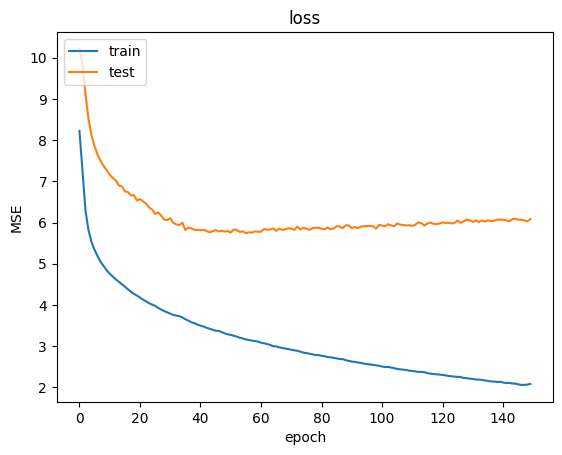

 ------------- ****** LAS-CLT-2) ****** ------------- 
fcst_start and fcst_end for LAS-CLT at FCST_ID 2 are: 432, 548
 For market (LAS-CLT-2) , we have 577.0 Pre-Covid data, 77.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-CLT-2 market, so ignored! *** 
 ------------- ****** LAS-CLT-3) ****** ------------- 
fcst_start and fcst_end for LAS-CLT at FCST_ID 3 are: 549, 637
 For market (LAS-CLT-3) , we have 348.0 Pre-Covid data, 459.0 Post-Covid data, and 196.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-CLT-3 market ***
 ------------- ****** LAS-CLT-4) ****** ------------- 
fcst_start and fcst_end for LAS-CLT at FCST_ID 4 are: 638, 798
 For market (LAS-CLT-4) , we have 284.0 Pre-Covid data, 472.0 Post-Covid data, and 209.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-CLT-4 ma

  0%|          | 0/1 [00:00<?, ?it/s]

 ------------- ****** LAS-DCA-1) ****** ------------- 
fcst_start and fcst_end for LAS-DCA at FCST_ID 1 are: 180, 1619
 For market (LAS-DCA-1) , we have 860.0 Pre-Covid data, 482.0 Post-Covid data, and 180.0 future data (from now to one year from now)
16/16 [==============================] - 4s 8ms/step
val plot for the no channel (org Cap)


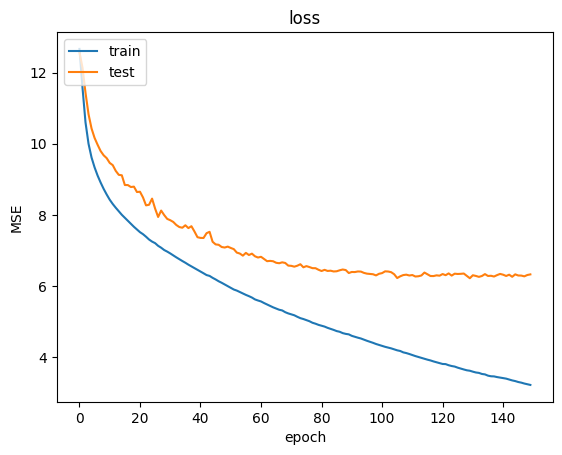

 Flights from LAS to DFW:


  0%|          | 0/13 [00:00<?, ?it/s]

 ------------- ****** LAS-DFW-1) ****** ------------- 
fcst_start and fcst_end for LAS-DFW at FCST_ID 1 are: 180, 324
 For market (LAS-DFW-1) , we have 28.0 Pre-Covid data, 471.0 Post-Covid data, and 106.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-DFW-1 market ***
 ------------- ****** LAS-DFW-2) ****** ------------- 
fcst_start and fcst_end for LAS-DFW at FCST_ID 2 are: 325, 428
 For market (LAS-DFW-2) , we have 853.0 Pre-Covid data, 483.0 Post-Covid data, and 180.0 future data (from now to one year from now)
16/16 [==============================] - 3s 8ms/step
 ------------- ****** LAS-DFW-3) ****** ------------- 
fcst_start and fcst_end for LAS-DFW at FCST_ID 3 are: 429, 509
 For market (LAS-DFW-3) , we have 188.0 Pre-Covid data, 459.0 Post-Covid data, and 178.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-DFW-3 market ***
 ----------

  0%|          | 0/3 [00:00<?, ?it/s]

 ------------- ****** LAS-JFK-1) ****** ------------- 
fcst_start and fcst_end for LAS-JFK at FCST_ID 1 are: 180, 569
 For market (LAS-JFK-1) , we have 372.0 Pre-Covid data, 0.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-JFK-1 market, so ignored! *** 
 ------------- ****** LAS-JFK-2) ****** ------------- 
fcst_start and fcst_end for LAS-JFK at FCST_ID 2 are: 570, 1014
 For market (LAS-JFK-2) , we have 633.0 Pre-Covid data, 2.0 Post-Covid data, and 4.0 future data (from now to one year from now)
1/1 [==============================] - 3s 3s/step
 ------------- ****** LAS-JFK-3) ****** ------------- 
fcst_start and fcst_end for LAS-JFK at FCST_ID 3 are: 1015, 1619
 For market (LAS-JFK-3) , we have 503.0 Pre-Covid data, 361.0 Post-Covid data, and 7.0 future data (from now to one year from now)
12/12 [==============================] - 2s 5ms/step
 Flights from LAS to LAX:


  0%|          | 0/9 [00:00<?, ?it/s]

 ------------- ****** LAS-LAX-1) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 1 are: 180, 389
 For market (LAS-LAX-1) , we have 304.0 Pre-Covid data, 59.0 Post-Covid data, and 34.0 future data (from now to one year from now)
2/2 [==============================] - 3s 8ms/step
val plot for the no channel (org Cap)


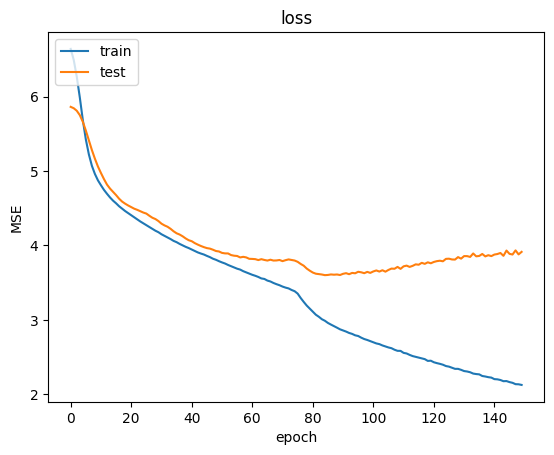

 ------------- ****** LAS-LAX-2) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 2 are: 390, 463
 For market (LAS-LAX-2) , we have 658.0 Pre-Covid data, 338.0 Post-Covid data, and 67.0 future data (from now to one year from now)
11/11 [==============================] - 2s 5ms/step
 ------------- ****** LAS-LAX-3) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 3 are: 464, 524
 For market (LAS-LAX-3) , we have 121.0 Pre-Covid data, 87.0 Post-Covid data, and 29.0 future data (from now to one year from now)
3/3 [==============================] - 2s 6ms/step
 ------------- ****** LAS-LAX-4) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 4 are: 525, 705
 For market (LAS-LAX-4) , we have 877.0 Pre-Covid data, 362.0 Post-Covid data, and 145.0 future data (from now to one year from now)
12/12 [==============================] - 3s 7ms/step
 ------------- ****** LAS-LAX-5) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at

  0%|          | 0/4 [00:00<?, ?it/s]

 ------------- ****** LAS-MIA-1) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 1 are: 180, 592
 For market (LAS-MIA-1) , we have 606.0 Pre-Covid data, 47.0 Post-Covid data, and 96.0 future data (from now to one year from now)
2/2 [==============================] - 2s 7ms/step
val plot for the no channel (org Cap)


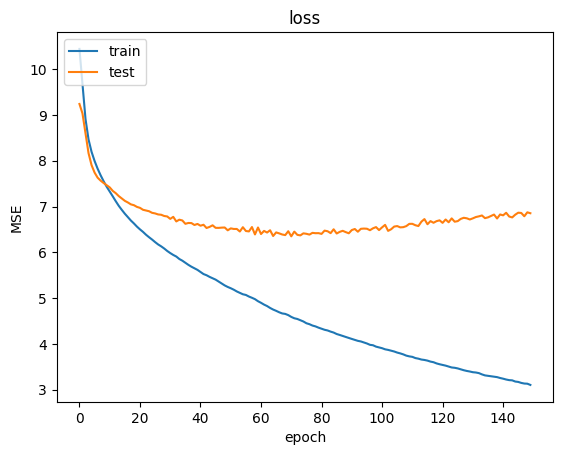

 ------------- ****** LAS-MIA-2) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 2 are: 593, 1022
 For market (LAS-MIA-2) , we have 804.0 Pre-Covid data, 406.0 Post-Covid data, and 74.0 future data (from now to one year from now)
13/13 [==============================] - 2s 7ms/step
 ------------- ****** LAS-MIA-3) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 3 are: 1023, 1447
 For market (LAS-MIA-3) , we have 856.0 Pre-Covid data, 406.0 Post-Covid data, and 167.0 future data (from now to one year from now)
13/13 [==============================] - 2s 6ms/step
 ------------- ****** LAS-MIA-4) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 4 are: 1448, 1619
 For market (LAS-MIA-4) , we have 20.0 Pre-Covid data, 214.0 Post-Covid data, and 39.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-MIA-4 market ***
 Flights from LAS to NRT:


  0%|          | 0/1 [00:00<?, ?it/s]

 ------------- ****** LAS-NRT-1) ****** ------------- 
fcst_start and fcst_end for LAS-NRT at FCST_ID 1 are: 180, 1619
 For market (LAS-NRT-1) , we have 9.0 Pre-Covid data, 0.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-NRT-1 market, so ignored! *** 
 Flights from LAS to ORD:


  0%|          | 0/7 [00:00<?, ?it/s]

 ------------- ****** LAS-ORD-1) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 1 are: 180, 461
 For market (LAS-ORD-1) , we have 758.0 Pre-Covid data, 305.0 Post-Covid data, and 134.0 future data (from now to one year from now)
10/10 [==============================] - 1s 5ms/step
val plot for the no channel (org Cap)


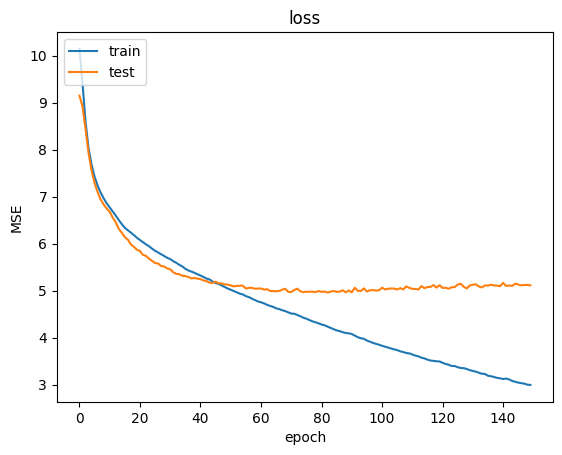

 ------------- ****** LAS-ORD-2) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 2 are: 462, 625
 For market (LAS-ORD-2) , we have 624.0 Pre-Covid data, 427.0 Post-Covid data, and 101.0 future data (from now to one year from now)
14/14 [==============================] - 1s 5ms/step
 ------------- ****** LAS-ORD-3) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 3 are: 626, 770
 For market (LAS-ORD-3) , we have 858.0 Pre-Covid data, 475.0 Post-Covid data, and 150.0 future data (from now to one year from now)
15/15 [==============================] - 1s 5ms/step
 ------------- ****** LAS-ORD-4) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 4 are: 771, 854
 For market (LAS-ORD-4) , we have 11.0 Pre-Covid data, 373.0 Post-Covid data, and 174.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-ORD-4 market ***
 ------------- ****** LAS-ORD-5) ****** ----------

  0%|          | 0/5 [00:00<?, ?it/s]

 ------------- ****** LAS-PHL-1) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 1 are: 180, 453
 For market (LAS-PHL-1) , we have 570.0 Pre-Covid data, 45.0 Post-Covid data, and 149.0 future data (from now to one year from now)
2/2 [==============================] - 2s 6ms/step
val plot for the no channel (org Cap)


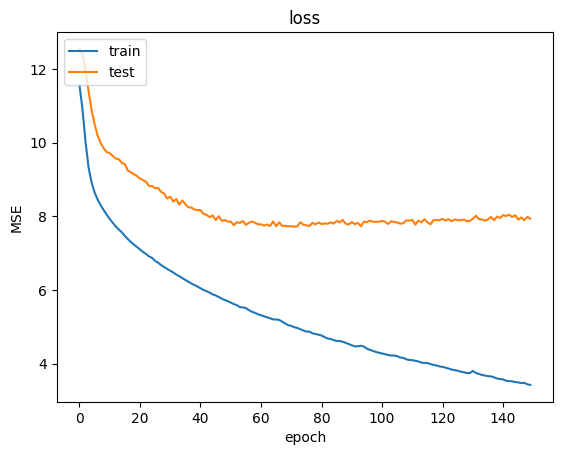

 ------------- ****** LAS-PHL-2) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 2 are: 454, 607
 For market (LAS-PHL-2) , we have 594.0 Pre-Covid data, 291.0 Post-Covid data, and 38.0 future data (from now to one year from now)
10/10 [==============================] - 2s 6ms/step
 ------------- ****** LAS-PHL-3) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 3 are: 608, 802
 For market (LAS-PHL-3) , we have 696.0 Pre-Covid data, 337.0 Post-Covid data, and 169.0 future data (from now to one year from now)
11/11 [==============================] - 2s 7ms/step
 ------------- ****** LAS-PHL-4) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 4 are: 803, 1091
 For market (LAS-PHL-4) , we have 153.0 Pre-Covid data, 142.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-PHL-4 market, so ignored! *** 
 ------------- ****** LAS-PHL-5) ****** ------------- 
fcst_start an

  0%|          | 0/7 [00:00<?, ?it/s]

 ------------- ****** LAS-PHX-1) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 1 are: 180, 423
 For market (LAS-PHX-1) , we have 876.0 Pre-Covid data, 478.0 Post-Covid data, and 149.0 future data (from now to one year from now)
15/15 [==============================] - 1s 5ms/step
val plot for the no channel (org Cap)


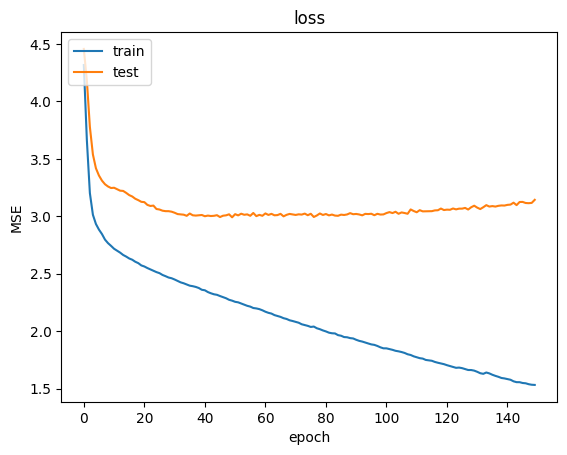

 ------------- ****** LAS-PHX-2) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 2 are: 424, 530
 For market (LAS-PHX-2) , we have 100.0 Pre-Covid data, 55.0 Post-Covid data, and 2.0 future data (from now to one year from now)
2/2 [==============================] - 2s 7ms/step
 ------------- ****** LAS-PHX-3) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 3 are: 531, 667
 For market (LAS-PHX-3) , we have 847.0 Pre-Covid data, 459.0 Post-Covid data, and 146.0 future data (from now to one year from now)
15/15 [==============================] - 2s 5ms/step
 ------------- ****** LAS-PHX-4) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 4 are: 668, 922
 For market (LAS-PHX-4) , we have 866.0 Pre-Covid data, 475.0 Post-Covid data, and 149.0 future data (from now to one year from now)
15/15 [==============================] - 2s 5ms/step
 ------------- ****** LAS-PHX-5) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at

  0%|          | 0/1 [00:00<?, ?it/s]

 ------------- ****** LAS-SJC-1) ****** ------------- 
fcst_start and fcst_end for LAS-SJC at FCST_ID 1 are: 180, 1619
 For market (LAS-SJC-1) , we have 1.0 Pre-Covid data, 3.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-SJC-1 market ***


In [14]:
from tqdm.notebook import trange, tqdm
from collections import defaultdict

orig = "LAS"

yesterday =  datetime.today() - timedelta(days=1)
next_year_today = datetime.today() + timedelta(days=365)

pull_start = '2017-09-01'
pull_end = next_year_today.strftime("%Y-%m-%d")

# Pre: pre-covid period, used for train and validation
Pre_start, Pre_end = '2017-09-01', '2020-01-30'
# Post: post-covid period, used for test
Post_start, Post_end = '2021-07-01',  yesterday.strftime("%Y-%m-%d")
# Future: Today till one year in future:
future_start , future_end = datetime.today().strftime("%Y-%m-%d") ,   next_year_today.strftime("%Y-%m-%d")

new_market= False
ulcc_list = ['NK','SY','F9'] # Spirit SunCountry Frontier 

# Extracting for Seas:
sea_col_Cap = ['week_x', 'week_y','dow_x', 'dow_y', 'avgrasm','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst' , 'seats_AA' , 'seats_OA' , 'seats_ulcc']
sea_col = ['week_x', 'week_y', 'dow_x', 'dow_y','avgrasm','dowavgrasm']

# Data reshaping parameters:
train_val_percentage = .9
time_series = False
seasenality_one_dimension = False 
window = 0 

# Model parameters;
epochs = 150
early_stop = 10
sea_dense = 128




kronos_2_nochannel_orgCap = defaultdict()
kronos_2_nochannel = defaultdict()
kronos_2_withchannel_orgCap = defaultdict()
kronos_2_withchannel = defaultdict()
kronos_2_simple = defaultdict()
kronos_2_simple_1layer = defaultdict() 

hcrt, mos, az = connect_to_servers()


# Pull all the dest given rig.
all_dest = find_all_dest_given_leg(orig , hcrt)
all_dest.pop(0) # Remove Austin

print(f"There are {len(all_dest)} FCSTs from {orig}")

for dest in tqdm(all_dest):
    print(f" Flights from {orig} to {dest}:")
    # Pull all the FCSTs
    fcst_id_df = get_fcst_given_leg(orig, dest, hcrt )    
    # Pull OAG:
    oag_df = get_oag_data(orig,dest, pull_start, pull_end)
    
    # Pull AA CAP: [Thi is also can only be used for past flights, can this be really used?]
    # cap_df = get_cap_data(orig,dest, pull_start, pull_end , cabin = 'Y') # THis one takes long time.

    # Processing: OAG Per Day:
    oag_kl_total_Per_Day_and_AA = oag_per_day(oag_df)

    
    for _,_ , fcst_id , fcst_start , fcst_end in tqdm(fcst_id_df.values):
        
        hcrt, mos, az = connect_to_servers()
        
        print(f" ------------- ****** {orig}-{dest}-{fcst_id}) ****** ------------- ")
        
        # print( fcst_id , fas, adf )
        print( f"fcst_start and fcst_end for {orig}-{dest} at FCST_ID {fcst_id} are: {fcst_start}, {fcst_end}") 
        
        #  Processing: OAG per FCST:
        oag_kl =  oag_per_fcst(oag_df, fcst_start, fcst_end )
        
        # Merge and Normalize: OAG per FCST and OAG per Day:
        oag_kl_fcst_total = pd.merge(oag_kl,oag_kl_total_Per_Day_and_AA ,on = "adj_dep_date", how='left',suffixes=('_fcst', '_day'))
        oag_kl_fcst_total = normalize_oag_kl_fcst_total(oag_kl_fcst_total)
        
        # Processing: AA Cap Per FCST 
        # cap_kl = aa_cap_fcst(cap_df,fcst_start, fcst_end )

        # Merge: OAG and AA Cap per FCST: [Where is this one used?]
        # oag_cap_kl = merge_oag_aacap(oag_kl,cap_kl)
        
        # Pull data from the file: pullData_FullPeriod.py
        df = pull_data(orig,dest,fcst_id,new_market)
        df = pull_seas(df, orig, dest)
        df['flightDepartureDate'] = pd.to_datetime(df['flightDepartureDate'], format='%Y/%m/%d')

        # Merge new features (including the total day seats) into current Kronos dataset by dep_date
        df = pd.merge(df,oag_kl_fcst_total, left_on=['flightDepartureDate'],\
              right_on=['adj_dep_date'], how='left')
        df.dropna(inplace=True)
        
        # processing: Group and pad the DF:
        post = group_and_pad(df)
        
        # Cut the 'post' data into Pre-covid and Post-covid parts
        Data_PRE = post[ (post['flightDepartureDate']>=Pre_start) & (post['flightDepartureDate']<=Pre_end) ]
        Data_POST = post[ (post['flightDepartureDate']>=Post_start) & (post['flightDepartureDate']<=Post_end) ]
        Data_FUTURE = post[ (post['flightDepartureDate']>=future_start) & (post['flightDepartureDate']<=future_end) ]
        
        print(f" For market ({orig}-{dest}-{fcst_id}) , we have {Data_PRE.shape[0]/14} Pre-Covid data, {Data_POST.shape[0]/14} Post-Covid data, and {Data_FUTURE.shape[0]/14} future data (from now to one year from now)")
        
        # TODO: This can be edited later, so we use the POST data to train....
        if len(Data_PRE) <= len(Data_POST):
            print(f" *** The Pre Covid data is less than the post covid data, so we ignore {orig}-{dest}-{fcst_id} market ***")
            continue
        
        # TODO: When merging models together this can be useefull for training porposes, but for now not usefull.
        if len(Data_FUTURE) == 0:
            print(f" *** There is no future flights for the {orig}-{dest}-{fcst_id} market, so ignored! *** ")
            continue
            
            
        # Train Kronos 2 (No Additional Feat (using sea_col)):
        use_channels = False
        seasenality_one_dimension = False
        train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col ,train_val_percentage = train_val_percentage , time_series = time_series, use_channels = use_channels,  seasenality_one_dimension = seasenality_one_dimension , window = window  )

        ret_para_Cap, ret_para_hist, kronos2_model = Kronos2_Model(para_epochs = epochs, para_early_stop = early_stop, para_model_name = 'para_Cap', para_sea_len = len(sea_col), para_sea_dense = sea_dense,
                                                                   train_list = train , val_list = val, test_list = test)

        kronos_2_nochannel_orgCap[f"{orig}-{dest}-{fcst_id}"] = { 
            "top_FvT" : [ret_para_Cap['top_FvT'].mean(), ret_para_Cap['top_FvT'].std(), ret_para_Cap['top_FvT_sqr'].mean()],
            "mid_FvT" : [ret_para_Cap['mid_FvT'].mean(), ret_para_Cap['mid_FvT'].std(), ret_para_Cap['mid_FvT_sqr'].mean()],
            "bot_FvT" : [ret_para_Cap['bot_FvT'].mean(), ret_para_Cap['bot_FvT'].std(), ret_para_Cap['bot_FvT_sqr'].mean()],
            "sum_FvT" : [ret_para_Cap['sum_FvT'].mean(), ret_para_Cap['sum_FvT'].std(), ret_para_Cap['sum_FvT_sqr'].mean()]
        }
        
        if fcst_id ==1:
            print("val plot for the no channel (org Cap)")
            plt.plot(ret_para_hist.history['loss'])
            plt.plot(ret_para_hist.history['val_loss'])
            plt.title('loss')
            plt.ylabel('MSE')
            plt.xlabel('epoch')
            plt.legend(['train','test'] , loc = "upper left")
            plt.show()

# # #         # + Cap 
#         use_channels = False
#         seasenality_one_dimension = False
#         train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap ,train_val_percentage = train_val_percentage , time_series = time_series, use_channels = use_channels,  seasenality_one_dimension = seasenality_one_dimension , window = window  )

#         ret_para_Cap, ret_para_hist, kronos2_model = Kronos2_Model(para_epochs = epochs, para_early_stop = early_stop, para_model_name = 'para_Cap', para_sea_len = len(sea_col_Cap), para_sea_dense = sea_dense,
#                                                                    train_list = train , val_list = val, test_list = test)

#         kronos_2_nochannel[f"{orig}-{dest}-{fcst_id}"] = { 
#             "top_FvT" : [ret_para_Cap['top_FvT'].mean(), ret_para_Cap['top_FvT'].std(), ret_para_Cap['top_FvT_sqr'].mean()],
#             "mid_FvT" : [ret_para_Cap['mid_FvT'].mean(), ret_para_Cap['mid_FvT'].std(), ret_para_Cap['mid_FvT_sqr'].mean()],
#             "bot_FvT" : [ret_para_Cap['bot_FvT'].mean(), ret_para_Cap['bot_FvT'].std(), ret_para_Cap['bot_FvT_sqr'].mean()],
#             "sum_FvT" : [ret_para_Cap['sum_FvT'].mean(), ret_para_Cap['sum_FvT'].std(), ret_para_Cap['sum_FvT_sqr'].mean()]
#         }
        
#         if fcst_id ==1:
#             print("val plot for the no channel + Cap")
#             plt.plot(ret_para_hist.history['loss'])
#             plt.plot(ret_para_hist.history['val_loss'])
#             plt.title('loss')
#             plt.ylabel('MSE')
#             plt.xlabel('epoch')
#             plt.legend(['train','test'] , loc = "upper left")
#             plt.show()
        
#         # + Channel - Cap:
#         use_channels = True
#         seasenality_one_dimension = False
#         train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col ,train_val_percentage = train_val_percentage , time_series = time_series, use_channels = use_channels,  seasenality_one_dimension = seasenality_one_dimension , window = window  )
#         channel_results , channel_hist,  kronos2s_model = Kronos2S_Model(para_epochs = epochs, para_early_stop =  early_stop, para_model_name = 'channel', para_sea_len = len(sea_col), para_sea_dense =  128, 
#                                                                          train_list = train , val_list = val, test_list = test)
        
#         kronos_2_withchannel_orgCap[f"{orig}-{dest}-{fcst_id}"] = { 
#             "top_FvT" : [channel_results['top_FvT'].mean(), channel_results['top_FvT'].std(), channel_results['top_FvT_sqr'].mean()],
#             "mid_FvT" : [channel_results['mid_FvT'].mean(), channel_results['mid_FvT'].std(), channel_results['mid_FvT_sqr'].mean()],
#             "bot_FvT" : [channel_results['bot_FvT'].mean(), channel_results['bot_FvT'].std(), channel_results['bot_FvT_sqr'].mean()],
#             "sum_FvT" : [channel_results['sum_FvT'].mean(), channel_results['sum_FvT'].std(), channel_results['sum_FvT_sqr'].mean()]
#         }        
#         if fcst_id ==1:
#             print( "val plot with Channel - Cap")
#             plt.plot(channel_hist.history['loss'])
#             plt.plot(channel_hist.history['val_loss'])
#             plt.title('loss')
#             plt.ylabel('MSE')
#             plt.xlabel('epoch')
#             plt.legend(['train','test'] , loc = "upper left")
#             plt.show()
            
            
        # + channel + Cap:
#         use_channels = True
#         seasenality_one_dimension = False
#         train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap ,train_val_percentage = train_val_percentage , time_series = time_series, use_channels = use_channels,  seasenality_one_dimension = seasenality_one_dimension , window = window  )
#         channel_results , channel_hist,  kronos2s_model = Kronos2S_Model(para_epochs = epochs, para_early_stop =  early_stop, para_model_name = 'channel', para_sea_len = len(sea_col_Cap), para_sea_dense =  128, 
#                                                                          train_list = train , val_list = val, test_list = test)
        
#         kronos_2_withchannel[f"{orig}-{dest}-{fcst_id}"] = { 
#             "top_FvT" : [channel_results['top_FvT'].mean(), channel_results['top_FvT'].std(), channel_results['top_FvT_sqr'].mean()],
#             "mid_FvT" : [channel_results['mid_FvT'].mean(), channel_results['mid_FvT'].std(), channel_results['mid_FvT_sqr'].mean()],
#             "bot_FvT" : [channel_results['bot_FvT'].mean(), channel_results['bot_FvT'].std(), channel_results['bot_FvT_sqr'].mean()],
#             "sum_FvT" : [channel_results['sum_FvT'].mean(), channel_results['sum_FvT'].std(), channel_results['sum_FvT_sqr'].mean()]
#         }        
#         if fcst_id ==1:
#             print( "val plot with channel")
#             plt.plot(channel_hist.history['loss'])
#             plt.plot(channel_hist.history['val_loss'])
#             plt.title('loss')
#             plt.ylabel('MSE')
#             plt.xlabel('epoch')
#             plt.legend(['train','test'] , loc = "upper left")
#             plt.show()
        
        
        
#         # Train Kronos 2 simple:
#         use_channels = True
#         seasenality_one_dimension = False
#         train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap ,train_val_percentage = train_val_percentage , time_series = time_series, use_channels = use_channels,  seasenality_one_dimension = seasenality_one_dimension , window = window  )
#         results_simp, hist_simp,  _ = Kronos2_Simplified_Model(para_epochs = epochs, para_early_stop =  early_stop, para_model_name = 'channel', para_sea_len = 11, para_sea_dense =  128, 
#                                                                          train_list = train , val_list = val, test_list = test)
        
#         kronos_2_simple[f"{orig}-{dest}-{fcst_id}"] = { 
#             "top_FvT" : [results_simp['top_FvT'].mean(), results_simp['top_FvT'].std(), results_simp['top_FvT_sqr'].mean()],
#             "mid_FvT" : [results_simp['mid_FvT'].mean(), results_simp['mid_FvT'].std(), results_simp['mid_FvT_sqr'].mean()],
#             "bot_FvT" : [results_simp['bot_FvT'].mean(), results_simp['bot_FvT'].std(), results_simp['bot_FvT_sqr'].mean()],
#             "sum_FvT" : [results_simp['sum_FvT'].mean(), results_simp['sum_FvT'].std(), results_simp['sum_FvT_sqr'].mean()]
#         } 
#         if fcst_id ==1:
#             print( "val plot Kronos2 Simple")
#             plt.plot(hist_simp.history['loss'])
#             plt.plot(hist_simp.history['val_loss'])
#             plt.title('loss')
#             plt.ylabel('MSE')
#             plt.xlabel('epoch')
#             plt.legend(['train','test'] , loc = "upper left")
#             plt.show()
            
            
        # Train Kronos 2 simple 1 layer:
#         use_channels = True
#         seasenality_one_dimension = False
#         train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap ,train_val_percentage = train_val_percentage , time_series = time_series, use_channels = use_channels,  seasenality_one_dimension = seasenality_one_dimension , window = window  )
#         results_simp_1l, hist_simp_1l,  _ = Kronos2_Simplified_1layer_Model(para_epochs = epochs, para_early_stop =  early_stop, para_model_name = 'channel', para_sea_len = 11, para_sea_dense =  128, 
#                                                                          train_list = train , val_list = val, test_list = test)
        
#         kronos_2_simple_1layer[f"{orig}-{dest}-{fcst_id}"] = { 
#             "top_FvT" : [results_simp_1l['top_FvT'].mean(), results_simp_1l['top_FvT'].std(), results_simp_1l['top_FvT_sqr'].mean()],
#             "mid_FvT" : [results_simp_1l['mid_FvT'].mean(), results_simp_1l['mid_FvT'].std(), results_simp_1l['mid_FvT_sqr'].mean()],
#             "bot_FvT" : [results_simp_1l['bot_FvT'].mean(), results_simp_1l['bot_FvT'].std(), results_simp_1l['bot_FvT_sqr'].mean()],
#             "sum_FvT" : [results_simp_1l['sum_FvT'].mean(), results_simp_1l['sum_FvT'].std(), results_simp_1l['sum_FvT_sqr'].mean()]
#         } 
#         if fcst_id ==1:
#             print( "val plot Kronos2 Simple 1 layer")
#             plt.plot(hist_simp_1l.history['loss'])
#             plt.plot(hist_simp_1l.history['val_loss'])
#             plt.title('loss')
#             plt.ylabel('MSE')
#             plt.xlabel('epoch')
#             plt.legend(['train','test'] , loc = "upper left")
#             plt.show()

        
        # break
    # break

Results from LAS:

Kronos 2 with channels and Kronos 2 simpilified, used 1D Seas:

|                  | **kronos_2_nochannel** | **Kronos_2_WithChannels** | **Kronos2_Simplified** |
|:----------------:|:----------------------:|:-------------------------:|:----------------------:|
| **top_FvT-mean** |        -0.495602       |         -0.386723         |        -0.460384       |
|  **top_FvT-sd**  |        3.060587        |          3.518470         |        3.368414        |
|  **top_FvT-mse** |        12.079965       |         15.934597         |        14.621277       |
| **mid_FvT-mean** |        -0.389216       |         -0.704238         |        -0.888993       |
|  **mid_FvT-sd**  |        5.165920        |          6.187158         |        5.736194        |
|  **mid_FvT-mse** |        29.092841       |         43.519421         |        36.211996       |
| **bot_FvT-mean** |        -0.385885       |         -0.588031         |        -1.079324       |
|  **bot_FvT-sd**  |        6.218318        |          6.980343         |        6.594847        |
|  **bot_FvT-mse** |        42.009036       |         57.815663         |        48.026316       |
| **sum_FvT-mean** |        -1.270703       |         -1.678993         |        -2.428701       |
|  **sum_FvT-sd**  |        8.270115        |         10.341137         |        9.394299        |
|  **sum_FvT-mse** |        73.741644       |         129.001303        |        97.773133       |

When using 2D Seas:

|                  | **Kronos_2_6Seas** | **kronos_2_CapSeas** | **kronos_2_6Seas_channel** | **kronos_2_CapSeas_Channel** | **kronos_2_1Layer** | **kronos_2_2Layer** |
|:----------------:|:------------------:|:--------------------:|:--------------------------:|:----------------------------:|---------------------|---------------------|
| **top_FvT-mean** |      -0.315303     | -0.492818            | **-0.278726**              | -0.449765                    | -0.516631           | -0.440491           |
|  **top_FvT-sd**  |    **3.041058**    | 3.126439             | **3.045776**               | 3.125397                     | 3.129684            | 3.155601            |
|  **top_FvT-mse** |      11.785193     | 12.809546            | **11.683365**              | 12.597175                    | 12.619842           | 13.133759           |
| **mid_FvT-mean** |    **-0.148206**   | -0.415367            | -0.227111                  | -0.405605                    | -0.648736           | -0.400417           |
|  **mid_FvT-sd**  |    **5.138118**    | 5.260132             | 5.141009                   | 5.229146                     | 5.319045            | 5.397234            |
|  **mid_FvT-mse** |    **28.400772**   | 30.170302            | **28.413749**              | 29.517101                    | 31.506014           | 31.881646           |
| **bot_FvT-mean** |      -0.421458     | **-0.379826**        | -0.409304                  | -0.440849                    | -1.295386           | -1.163147           |
|  **bot_FvT-sd**  |      6.166930      | 6.233778             | **6.124670**               | 6.174050                     | 6.236110            | 6.453304            |
|  **bot_FvT-mse** |      41.547433     | 41.845668            | **41.069482**              | 41.806217                    | 43.544506           | 47.850181           |
| **sum_FvT-mean** |    **-0.884967**   | -1.288011            | -0.915141                  | -1.296220                    | -2.460753           | -2.004055           |
|  **sum_FvT-sd**  |      8.358592      | 8.399815             | **8.264797**               | 8.275040                     | 8.708174            | 8.956874            |
|  **sum_FvT-mse** |      73.610328     | 76.119255            | **71.665813**              | 73.121215                    | 85.417073           | 89.968639           |

In [21]:
pd.DataFrame(kronos_2_nochannel)

,LAS-CLT-1,LAS-CLT-5,LAS-CLT-6,LAS-CLT-7,LAS-DCA-1,LAS-DFW-2,LAS-DFW-4,LAS-DFW-5,LAS-DFW-6,LAS-DFW-8,LAS-DFW-9,LAS-DFW-10,LAS-DFW-11,LAS-DFW-13,LAS-JFK-2,LAS-JFK-3,LAS-LAX-1,LAS-LAX-2,LAS-LAX-3,LAS-LAX-4,LAS-LAX-5,LAS-LAX-6,LAS-LAX-7,LAS-LAX-8,LAS-LAX-9,LAS-MIA-1,LAS-MIA-2,LAS-MIA-3,LAS-ORD-1,LAS-ORD-2,LAS-ORD-3,LAS-ORD-5,LAS-ORD-6,LAS-PHL-1,LAS-PHL-2,LAS-PHL-3,LAS-PHL-5,LAS-PHX-1,LAS-PHX-2,LAS-PHX-3,LAS-PHX-4,LAS-PHX-5,LAS-PHX-6
top_FvT,"[-0.31762173016662776, 2.268749297237456, 5.24...","[-0.6121267377174289, 3.24360911432257, 10.893...","[-0.28146177732536987, 1.6340986044489496, 2.7...","[-0.4696561912710185, 1.986427964730853, 4.165...","[-1.1393433536088886, 4.122800332592202, 18.29...","[-0.19861796579087262, 3.0046626389996303, 9.0...","[-0.30099123202620237, 4.333609042063736, 18.8...","[-0.5176448110949129, 4.686969551146433, 22.23...","[-0.5343774195463175, 4.632054753828883, 21.73...","[-1.1692878031269052, 4.494211540735884, 21.56...","[-0.3359401564331736, 4.502969093544259, 20.38...","[1.3734817541028472, 5.328094999004095, 30.265...","[-1.5951690062038908, 5.258665999626832, 30.18...","[-0.006801491299102478, 1.9297597166558118, 3....","[-0.7570165231424782, 1.602910543626674, 3.050...","[-0.16269024036352991, 2.3668233569318855, 5.6...","[0.02303827559625049, 0.7687749312049468, 0.59...","[0.027730384195306247, 1.3453160283461103, 1.8...","[0.04689917653803262, 1.6309037549536227, 2.65...","[-0.30493603822585136, 1.7350494808528583, 3.1...","[-0.12759657132430016, 1.4168761852132796, 2.0...","[-0.3798997272790058, 2.002906205202765, 4.154...","[-0.3081031784053526, 1.8857006072850242, 3.64...","[0.05830216398426153, 2.2795808861669515, 5.19...","[0.08642140457175822, 0.9207803026643885, 0.85...","[-2.355410100185336, 6.061393436994661, 42.194...","[-1.7777446224731128, 7.250967043281392, 55.72...","[0.14066870780356583, 4.013551898448623, 16.12...","[-0.28967045046316864, 2.2806996692951875, 5.2...","[-0.2546105954558243, 3.1760471478518957, 10.1...","[-0.3684829910392876, 3.115013443013792, 9.837...","[-0.6046485689346345, 3.735992206889661, 14.31...","[-1.1529130666744187, 4.905456103956572, 25.36...","[-0.9243270336399003, 6.577385391950166, 44.04...","[-1.5848463985304309, 4.353505268245275, 21.45...","[-1.3879553541525127, 4.434305725634389, 21.58...","[-0.5584709512890355, 2.5659963215377144, 6.89...","[-0.27147002019426403, 2.644947045078653, 7.06...","[-0.6772576901502907, 2.2937417240385787, 5.70...","[-0.5248961975314761, 2.5472913154678807, 6.76...","[0.3618318401038487, 2.7618486199228074, 7.757...","[-0.3777637220214754, 2.298130706514138, 5.423...","[0.03180132156382916, 1.4938433644326334, 2.23..."
mid_FvT,"[-2.0062960725919243, 5.474358511774891, 33.98...","[-2.0760226171106666, 6.371783737100803, 44.90...","[-1.1771941847423901, 5.082330812160417, 27.21...","[-0.889422478691275, 5.433887741026973, 30.309...","[-1.3849589212026312, 5.6256191395722475, 33.5...","[-0.2443783025793729, 4.418646343630593, 19.58...","[-0.2289123010307935, 4.6902810634690315, 22.0...","[-1.1698774349595973, 5.052735639364053, 26.89...","[0.1967893516350123, 5.070331410736472, 25.743...","[-0.8403470077800714, 5.486604475388451, 30.80...","[0.10950796607739843, 5.232751987882175, 27.38...","[-0.7803611828197453, 7.817296656682713, 61.69...","[-1.6999605913978524, 6.6343543510358, 46.8756...","[0.029955924657606554, 3.5631664545924626, 12....","[-2.1910651613559042, 4.656928245368408, 25.71...","[-0.7104750162105378, 5.6263530797697, 32.1540...","[-0.014680196933073982, 3.407863817347578, 11....","[1.4448514050766845, 3.7453885305024817, 16.11...","[-0.49805004232926775, 4.030969928905773, 16.4...","[0.7144059931703166, 4.1470864436696395, 17.70...","[0.2355603755513403, 3.4212873222883937, 11.75...","[0.6591947275566236, 3.703717702058277, 14.147...","[-0.14127292606489, 4.061704931576309, 16.5128...","[0.02750651678870628, 5.053107841219483, 25.52...","[0.9132196636977861, 3.332794699163852, 11.935...","[-1.447292978

In [15]:
pd.DataFrame(kronos_2_nochannel_orgCap)

,LAS-CLT-1,LAS-CLT-5,LAS-CLT-6,LAS-CLT-7,LAS-DCA-1,LAS-DFW-2,LAS-DFW-4,LAS-DFW-5,LAS-DFW-6,LAS-DFW-8,LAS-DFW-9,LAS-DFW-10,LAS-DFW-11,LAS-DFW-13,LAS-JFK-2,LAS-JFK-3,LAS-LAX-1,LAS-LAX-2,LAS-LAX-3,LAS-LAX-4,LAS-LAX-5,LAS-LAX-6,LAS-LAX-7,LAS-LAX-8,LAS-LAX-9,LAS-MIA-1,LAS-MIA-2,LAS-MIA-3,LAS-ORD-1,LAS-ORD-2,LAS-ORD-3,LAS-ORD-5,LAS-ORD-6,LAS-PHL-1,LAS-PHL-2,LAS-PHL-3,LAS-PHL-5,LAS-PHX-1,LAS-PHX-2,LAS-PHX-3,LAS-PHX-4,LAS-PHX-5,LAS-PHX-6
top_FvT,"[-0.4608518105105821, 2.1289544314709703, 4.74...","[-0.7310062347720183, 3.0560180308928695, 9.87...","[-0.28578897796069247, 1.5863697227917408, 2.5...","[-0.4491717168334414, 1.8272814812557512, 3.53...","[-0.9999245729944654, 4.089093375234939, 17.71...","[-0.0916009487848535, 2.5341380834953164, 6.42...","[0.5830608035062915, 4.814797001076562, 23.518...","[0.4912579470813503, 5.0588968168535065, 25.82...","[0.41454258482699985, 4.991158513792785, 25.07...","[-0.7911050830000192, 4.11732472386888, 17.575...","[-0.10383286626662641, 4.1068181361543905, 16....","[1.4622284059973698, 5.3010807920143375, 30.23...","[-1.3891415457738023, 5.078969621962574, 27.70...","[0.19546557508176968, 1.9904304835532103, 3.99...","[-0.8787744673235076, 2.2025640109040197, 5.45...","[-0.31292245698404175, 2.3138675878752637, 5.4...","[-0.026115960889150892, 0.7705212069521277, 0....","[0.09917678658371921, 1.4170285159503893, 2.01...","[-0.10772082349390599, 1.464150458888434, 2.15...","[-0.35885457091560236, 1.702437762497532, 3.02...","[-0.2330826044669184, 1.4410115874293232, 2.13...","[-0.36404256463757495, 1.9513316202515902, 3.9...","[-0.33489238284086503, 1.8498892501310102, 3.5...","[0.21638697626165287, 2.2308343016376213, 5.02...","[0.02615837279723297, 0.9024021839267696, 0.81...","[-0.2797382772305059, 5.844645591560508, 34.17...","[-0.39633627603026855, 4.992317406216653, 25.0...","[-0.3877662827013985, 3.5733341482532155, 12.9...","[-0.28583447632464176, 2.2450163850382494, 5.1...","[-0.4560961876535506, 2.9441106148560094, 8.87...","[-0.2820925117966141, 3.214703956702557, 10.41...","[-0.32907364486761065, 3.7257861705100095, 13....","[-1.2548558426155034, 5.077566161177998, 27.32...","[-0.7929925057120503, 6.589257921104875, 43.97...","[-1.4887197527041396, 4.395387050094842, 21.53...","[-1.4874050643840493, 4.575317164458707, 23.14...","[-0.64983549203097, 2.6527434134695516, 7.4580...","[-0.42577438497611153, 2.2489229459469846, 5.2...","[-0.7405713221352207, 2.3146250851817243, 5.89...","[-0.216635265855564, 2.5741136858883396, 6.671...","[-0.0830192722504804, 2.507427618346377, 6.293...","[-0.47899530199037743, 2.2573091371504264, 5.3...","[0.10218955599694836, 1.6683047704660328, 2.79..."
mid_FvT,"[-0.7777613856212988, 4.992015525818006, 25.52...","[-0.9324671800061562, 5.888718871326243, 35.53...","[-0.3581089024605937, 4.8493322212363585, 23.6...","[-0.3729195728771784, 5.223201647710054, 27.41...","[-0.9625575750655339, 5.629550059466315, 32.61...","[-0.23431695676348796, 4.389119597413417, 19.3...","[0.0897121620439015, 4.660848534619823, 21.728...","[-0.9722255603763398, 4.899246213090324, 24.94...","[-0.16994658562731207, 5.179432895397738, 26.8...","[-1.2670317027839788, 5.352626429826538, 30.25...","[-0.41111043074206277, 5.0954058327997185, 26....","[-0.6767010986270331, 7.823284497804666, 61.64...","[0.1278547720866446, 6.769946987654033, 45.818...","[0.21579087236157093, 3.8399394234651085, 14.7...","[0.6192835526806968, 3.9750931659470767, 15.62...","[-0.8934989722219469, 6.626213205760361, 44.69...","[-0.034586864708501114, 3.1502259021091876, 9....","[1.1836398456812716, 3.715603970168005, 15.203...","[-0.672136309154071, 3.640950167368978, 13.693...","[0.7013570811112051, 4.2611590836679705, 18.64...","[0.14713658868710555, 2.9888575576386422, 8.95...","[0.16320953347953665, 3.5861778704362774, 12.8...","[-0.18567863242878957, 3.9562633244586376, 15....","[0.0553397981072275, 4.767001909266295, 22.720...","[0.6390995208512165, 3.345983163647238, 11.597...","[0.4505704861

In [17]:
pd.DataFrame(kronos_2_simple)

,LAS-CLT-1,LAS-CLT-5,LAS-CLT-6,LAS-CLT-7,LAS-DCA-1,LAS-DFW-2,LAS-DFW-4,LAS-DFW-5,LAS-DFW-6,LAS-DFW-8,LAS-DFW-9,LAS-DFW-10,LAS-DFW-11,LAS-DFW-13,LAS-JFK-2,LAS-JFK-3,LAS-LAX-1,LAS-LAX-2,LAS-LAX-3,LAS-LAX-4,LAS-LAX-5,LAS-LAX-6,LAS-LAX-7,LAS-LAX-8,LAS-LAX-9,LAS-MIA-1,LAS-MIA-2,LAS-MIA-3,LAS-ORD-1,LAS-ORD-2,LAS-ORD-3,LAS-ORD-5,LAS-ORD-6,LAS-PHL-1,LAS-PHL-2,LAS-PHL-3,LAS-PHL-5,LAS-PHX-1,LAS-PHX-2,LAS-PHX-3,LAS-PHX-4,LAS-PHX-5,LAS-PHX-6
top_FvT,"[-0.686909644663781, 2.257775629313344, 5.5686...","[-0.4410676439135476, 3.683340642464325, 13.75...","[-0.323247142494793, 1.768170403451663, 3.2303...","[-0.710534469835578, 1.9674571648912456, 4.374...","[-1.4923704584769153, 4.768775090091931, 24.96...","[-0.22788470149621046, 3.7273806090873487, 13....","[-0.08683065715629557, 5.2798438891677115, 27....","[-0.43015707178010204, 4.501496550300877, 20.4...","[-0.13728698294408656, 5.127958729100986, 26.3...","[-0.9369288976862707, 5.0456068372929055, 26.3...","[-0.8073268771808012, 5.77384244783783, 33.982...","[0.6149277922534644, 7.304679479460497, 53.718...","[-1.0343207156732386, 5.4624346077642825, 30.8...","[-0.33220638633167143, 1.8213712907517097, 3.4...","[-1.0357142857142858, 2.1166385449950424, 5.39...","[-0.5376041356420532, 2.632122272712436, 7.215...","[-0.0575280731473993, 0.769793339638487, 0.595...","[-0.011427869756800829, 1.5641041434378327, 2....","[0.011484235106771875, 1.907583300279712, 3.63...","[-0.4081719217413837, 1.813757364046477, 3.455...","[-0.2297249568838683, 1.4221607573885322, 2.07...","[-0.4678286018573266, 1.9942444878037833, 4.19...","[-0.44708385038393317, 2.002697170017961, 4.20...","[0.07312287552182054, 2.4320144026804504, 5.91...","[-0.13794055190527818, 1.070754749735794, 1.16...","[-0.9546563485010979, 6.629652741524493, 44.73...","[-0.7990742494330366, 6.205567817092018, 39.14...","[-0.41525625500940744, 4.688860537566233, 22.1...","[-0.26661153959208655, 2.8346832573879164, 8.1...","[-0.7550499715299416, 3.2854859603204463, 11.3...","[-0.6853003921330161, 3.654129454754654, 13.82...","[-0.45952583530873387, 3.9244624950691627, 15....","[-0.5443796135553841, 4.237263432117419, 18.23...","[-0.9060458502953961, 6.858702086006824, 47.78...","[-1.7102761259309807, 4.4408272274066345, 22.6...","[-1.6491969150952575, 4.6175734074651436, 24.0...","[-0.803824579415358, 2.937168523213304, 9.2714...","[0.291133683406259, 2.697520766412014, 7.36014...","[-0.6044204335147307, 2.357828424466479, 5.912...","[-0.12493658621533317, 3.004345215395948, 9.04...","[-0.15828797514182807, 2.968793790337713, 8.83...","[-0.5534105431641249, 2.5648780690790876, 6.88...","[-0.24872482184361558, 1.6154355919594066, 2.6..."
mid_FvT,"[-1.345382202931462, 5.684328137822469, 34.116...","[-1.1864904363930837, 6.879451214765718, 48.72...","[-1.5613015961964014, 5.742172452965817, 35.40...","[-1.8120666918821238, 6.093104237728931, 40.39...","[-2.6842080529551526, 6.674094217406294, 51.74...","[0.13824327707679773, 5.01019000499495, 25.117...","[-0.35417821652408926, 5.169814799709791, 26.8...","[-1.570739064284858, 5.198530551086591, 29.487...","[-0.21733160874709326, 5.6477052633691525, 31....","[-1.0227214584596724, 6.52214511445773, 43.577...","[-1.2165373417094845, 5.940494932324561, 36.76...","[-0.26190335715605667, 8.848079671314094, 78.3...","[1.1595887235093614, 6.883656537525193, 48.698...","[-0.11437517151414323, 4.413591664202824, 19.4...","[-0.64426787091153, 7.3426695156468815, 52.404...","[-1.6160720214810227, 7.500200355018885, 58.85...","[0.2301569499490336, 3.8664802695571363, 14.98...","[1.9822414545793847, 5.511194906412714, 34.294...","[-0.38895887280257235, 4.72526287380992, 22.45...","[1.0354483404736443, 5.6088382250267, 32.52468...","[-0.24177156684379897, 4.164392362128507, 17.3...","[0.2931099363923373, 4.274864129575253, 18.353...","[-0.6388779361911604, 4.682483295262973, 22.32...","[-1.218076006604687, 6.189422043128651, 39.780...","[-0.4925795535253688, 3.8821283472443633, 15.3...","[-0.849111132

In [14]:
pd.DataFrame(kronos_2_simple_1layer)

,LAS-CLT-1,LAS-CLT-5,LAS-CLT-6,LAS-CLT-7,LAS-DCA-1,LAS-DFW-2,LAS-DFW-4,LAS-DFW-5,LAS-DFW-6,LAS-DFW-8,LAS-DFW-9,LAS-DFW-10,LAS-DFW-11,LAS-DFW-13,LAS-JFK-2,LAS-JFK-3,LAS-LAX-1,LAS-LAX-2,LAS-LAX-3,LAS-LAX-4,LAS-LAX-5,LAS-LAX-6,LAS-LAX-7,LAS-LAX-8,LAS-LAX-9,LAS-MIA-1,LAS-MIA-2,LAS-MIA-3,LAS-ORD-1,LAS-ORD-2,LAS-ORD-3,LAS-ORD-5,LAS-ORD-6,LAS-PHL-1,LAS-PHL-2,LAS-PHL-3,LAS-PHL-5,LAS-PHX-1,LAS-PHX-2,LAS-PHX-3,LAS-PHX-4,LAS-PHX-5,LAS-PHX-6
top_FvT,"[-0.5029024100325126, 2.1460644251012906, 4.85...","[-0.5704663539138021, 3.4175831709620716, 12.0...","[-0.5072159537276283, 1.7202385727302294, 3.21...","[-0.7251443807635181, 1.9806398627468005, 4.44...","[-1.3343101792614402, 4.652323094627284, 23.42...","[-0.20770670405232108, 3.9544623960558822, 15....","[-0.1874512329084278, 5.0959617854173445, 25.9...","[-0.669619744475903, 4.599042938052723, 21.596...","[-0.09068026036214727, 5.402062723153845, 29.1...","[-1.3807257000283635, 4.574382648126835, 22.82...","[-0.39661790693895355, 6.685423900411405, 44.8...","[0.8547832454356764, 7.99513036788136, 64.6311...","[-1.0428803041089096, 5.083842837020139, 26.91...","[-0.29637946899810785, 1.9166559183246337, 3.7...","[-0.8861560927970069, 1.9980434001713232, 4.63...","[-0.6178340068561192, 2.684887932622973, 7.588...","[-0.0850226698876257, 0.7998776424300252, 0.64...","[-0.14496858855491115, 1.411349761870821, 2.01...","[-0.29096754043390366, 1.5056378783454247, 2.3...","[-0.48379146746734036, 1.712984181279192, 3.16...","[-0.2904835104588977, 1.5472906441683332, 2.47...","[-0.46947875117453247, 2.088533163397375, 4.58...","[-0.49392100118711824, 2.0971217688193122, 4.6...","[0.0583965573328972, 2.4653224668977294, 6.079...","[-0.11238216693360112, 0.9824562410245778, 0.9...","[-1.0333593546559936, 5.560182624231642, 31.89...","[-1.5178324926383013, 6.658033549029856, 46.62...","[-0.34750576763471225, 4.234433216902751, 18.0...","[-0.45176225011281007, 2.661207172405185, 7.28...","[-0.7530090458933238, 3.2922556419661064, 11.4...","[-0.8659583408776624, 3.5763601823135516, 13.5...","[-0.6151366326418217, 4.1755510385988455, 17.8...","[-0.6717275134577472, 3.925343332280937, 15.84...","[-1.0312100904328483, 6.754778914716144, 46.61...","[-1.818551023068927, 4.633751252926474, 24.773...","[-1.8665701952897251, 4.986893287359932, 28.34...","[-0.794560984066029, 2.905069544321294, 9.0691...","[-0.1051767767586574, 2.4704970899855705, 6.11...","[-0.5249778981399557, 2.508021182529099, 6.551...","[0.2936575782221556, 3.3245353158369633, 11.13...","[-0.27408094513201886, 3.275970826517975, 10.8...","[-0.47327176997151926, 2.422607404399268, 6.09...","[-0.22683718918094342, 1.503027268353832, 2.30..."
mid_FvT,"[-1.376465445182041, 5.711492775029289, 34.510...","[-1.7034302614827708, 6.322151879253865, 42.86...","[-1.6907415098530127, 5.74233469319803, 35.826...","[-2.6389233915585937, 6.027543919262694, 43.28...","[-2.657363092823853, 7.141838144577941, 58.059...","[-0.3948781532400142, 4.979373187937067, 24.94...","[-0.9603012140598429, 5.037610060882161, 26.29...","[-1.8364137238720082, 5.150033611905752, 29.89...","[-0.5246028920397006, 5.368930699191145, 29.09...","[-1.357759343891222, 6.319570477605337, 41.774...","[-1.5012737141529982, 5.936693643112877, 37.49...","[-0.7070262953155901, 8.712199294968228, 76.37...","[1.1258141762512306, 7.067716130451089, 51.187...","[-0.23839085903762944, 4.367546987161841, 19.1...","[-0.6314513124525547, 4.73213786315303, 21.992...","[-1.9320402910315773, 6.807635660896923, 50.06...","[0.4061924543797735, 3.991035338445189, 16.074...","[1.0776904987595026, 4.948787744613138, 25.645...","[-0.9567844051695334, 4.347158573565311, 19.79...","[0.4840469525269158, 5.651475730928678, 32.166...","[-0.23133422956290287, 4.106011824065237, 16.9...","[-0.03998732396943883, 4.021251813192264, 16.1...","[-0.45021695346089735, 4.580234427009596, 21.1...","[-0.8648203921436312, 5.886908552971204, 35.39...","[-0.22802803381654818, 3.546608668741337, 12.6...","[-1.086444224

In [15]:
def find_mean_all(kronos_2_results):

    values_nochannel = defaultdict(list)
    for key, value in kronos_2_results.items():

        for k,v in value.items():
            values_nochannel[f"{k}-mean"].append(v[0])
            values_nochannel[f"{k}-sd"].append(v[1])
            values_nochannel[f"{k}-mse"].append(v[2])

    return pd.DataFrame(values_nochannel).mean()

In [16]:
find_mean_all(kronos_2_nochannel_orgCap)

top_FvT-mean    -0.315303
top_FvT-sd       3.041058
top_FvT-mse     11.785193
mid_FvT-mean    -0.148206
mid_FvT-sd       5.138118
mid_FvT-mse     28.400772
bot_FvT-mean    -0.421458
bot_FvT-sd       6.166930
bot_FvT-mse     41.547433
sum_FvT-mean    -0.884967
sum_FvT-sd       8.358592
sum_FvT-mse     73.610328
dtype: float64

In [17]:
find_mean_all(kronos_2_nochannel)

top_FvT-mean    -0.492818
top_FvT-sd       3.126439
top_FvT-mse     12.809546
mid_FvT-mean    -0.415367
mid_FvT-sd       5.260132
mid_FvT-mse     30.170302
bot_FvT-mean    -0.379826
bot_FvT-sd       6.233778
bot_FvT-mse     41.845668
sum_FvT-mean    -1.288011
sum_FvT-sd       8.399815
sum_FvT-mse     76.119255
dtype: float64

In [18]:
find_mean_all(kronos_2_withchannel_orgCap)

top_FvT-mean    -0.278726
top_FvT-sd       3.045776
top_FvT-mse     11.683365
mid_FvT-mean    -0.227111
mid_FvT-sd       5.141009
mid_FvT-mse     28.413749
bot_FvT-mean    -0.409304
bot_FvT-sd       6.124670
bot_FvT-mse     41.069482
sum_FvT-mean    -0.915141
sum_FvT-sd       8.264797
sum_FvT-mse     71.665813
dtype: float64

In [25]:
find_mean_all(kronos_2_withchannel)

top_FvT-mean    -0.449765
top_FvT-sd       3.125397
top_FvT-mse     12.597175
mid_FvT-mean    -0.405605
mid_FvT-sd       5.229146
mid_FvT-mse     29.517101
bot_FvT-mean    -0.440849
bot_FvT-sd       6.174050
bot_FvT-mse     41.806217
sum_FvT-mean    -1.296220
sum_FvT-sd       8.275040
sum_FvT-mse     73.121215
dtype: float64

In [19]:
find_mean_all(kronos_2_simple) 

top_FvT-mean    -0.440491
top_FvT-sd       3.155601
top_FvT-mse     13.133759
mid_FvT-mean    -0.400417
mid_FvT-sd       5.397234
mid_FvT-mse     31.881646
bot_FvT-mean    -1.163147
bot_FvT-sd       6.453304
bot_FvT-mse     47.850181
sum_FvT-mean    -2.004055
sum_FvT-sd       8.956874
sum_FvT-mse     89.968639
dtype: float64

In [24]:
find_mean_all(kronos_2_simple_1layer) 

top_FvT-mean    -0.516631
top_FvT-sd       3.129684
top_FvT-mse     12.619842
mid_FvT-mean    -0.648736
mid_FvT-sd       5.319045
mid_FvT-mse     31.506014
bot_FvT-mean    -1.295386
bot_FvT-sd       6.236110
bot_FvT-mse     43.544506
sum_FvT-mean    -2.460753
sum_FvT-sd       8.708174
sum_FvT-mse     85.417073
dtype: float64

In [24]:
test[1][0][0][0]

array([0.00071838, 0.53413224, 0.037     , 0.274     , 0.645     ,
       0.375     , 0.        , 0.        , 0.375     , 0.        ,
       0.        ], dtype=float32)

In [36]:
train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap ,train_val_percentage = 0.9 , time_series = False, use_channels = False,  seasenality_one_dimension = False , window = 0  )
ret_para_Cap, ret_para_hist, kronos2_model = Kronos2_Model(5, 12, 'para_Cap', len(sea_col_Cap), 160, train, val, test)



1/1 [==============================] - 2s 2s/step


In [24]:
kronos2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 14, 10)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 14, 11)]  0           []                               
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (None, 1, 16, 10)    3904        ['input_1[0][0]']                
                                                                                                  
 conv_lstm1d_1 (ConvLSTM1D)     (None, 1, 16, 11)    3904        ['input_2[0][0]']                
                                                                                              

In [21]:
train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap ,train_val_percentage = 0.9 , time_series = False, use_channels = True,  seasenality_one_dimension = False , window = 0  )

ret_para_Cap, ret_para_Cap_hist,  kronos2S_model = Kronos2S_Model(para_epochs = 50, para_early_stop =  5, para_model_name = 'para_cap', para_sea_len = 11, para_sea_dense =  160,
             train_list = train , val_list = val, test_list = test)


15/15 [==============================] - 2s 6ms/step


In [22]:
kronos2S_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 2, 7, 10  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 14, 11)]  0           []                               
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 1, 16, 7, 10  4672        ['input_1[0][0]']                
                                )                                                                 
                                                                                              

In [47]:

train, val, test = get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap ,train_val_percentage = 0.9 , time_series = False, use_channels = True,  seasenality_one_dimension = False , window = 0  )

results_simp, hist_simp,  model_simp = Kronos2_Simplified_1layer_Model(para_epochs = 5, para_early_stop =  5, para_model_name = 'para_cap', para_sea_len = 11, para_sea_dense =  160,
             train_list = train , val_list = val, test_list = test)

15/15 [==============================] - 0s 3ms/step


In [50]:
history = History()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
# mc = ModelCheckpoint( 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, period=1)
base_hist = kronos2S_model.fit([train[0].reshape(len(train[0]),1,2,7,10), train[1]], train[2], epochs = 10, batch_size = 100, validation_data = ([val[0].reshape(len(val[0]),1,2,7,10), val[1]], val[2]), verbose = 1 ) #, callbacks=[history,es,mc])


Epoch 1/10
1/1 [==============================] - 0s 125ms/step - loss: 3.4365
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 3.4368
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 3.4372
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 3.4375
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 3.4375
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 3.4373
Epoch 7/10
1/1 [==============================] - 0s 52ms/step - loss: 3.4369
Epoch 8/10
1/1 [==============================] - 0s 54ms/step - loss: 3.4365
Epoch 9/10
1/1 [==============================] - 0s 45ms/step - loss: 3.4361
Epoch 10/10
1/1 [==============================] - 0s 50ms/step - loss: 3.4359


In [48]:
model_simp.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 10, 2)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 11, 14)]     0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 7, 10, 16)    304         ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 11, 16)       688         ['input_2[0][0]']                
                                                                                              

In [164]:
# top/mid/bot/sum - FvT mean/std/MSE
print('results_simp')
print([results_simp['top_FvT'].mean(), results_simp['top_FvT'].std(), results_simp['top_FvT_sqr'].mean()])
print([results_simp['mid_FvT'].mean(), results_simp['mid_FvT'].std(), results_simp['mid_FvT_sqr'].mean()])
print([results_simp['bot_FvT'].mean(), results_simp['bot_FvT'].std(), results_simp['bot_FvT_sqr'].mean()])
print([results_simp['sum_FvT'].mean(), results_simp['sum_FvT'].std(), results_simp['sum_FvT_sqr'].mean()])


results_simp
[-0.7266687764621266, 4.294174815677168, 18.967315045809244]
[-0.7072737753301576, 5.737241826752663, 33.41498433283342]
[-1.4109995611528219, 6.154072854039739, 39.86215676923362]
[-2.844942116259255, 9.42001196110387, 96.82709772212404]


In [168]:
# top/mid/bot/sum - FvT mean/std/MSE
print('results_simp2')
print([results_simp['top_FvT'].mean(), results_simp['top_FvT'].std(), results_simp['top_FvT_sqr'].mean()])
print([results_simp['mid_FvT'].mean(), results_simp['mid_FvT'].std(), results_simp['mid_FvT_sqr'].mean()])
print([results_simp['bot_FvT'].mean(), results_simp['bot_FvT'].std(), results_simp['bot_FvT_sqr'].mean()])
print([results_simp['sum_FvT'].mean(), results_simp['sum_FvT'].std(), results_simp['sum_FvT_sqr'].mean()])


results_simp2
[-0.7266687764621266, 4.294174815677168, 18.967315045809244]
[-0.7072737753301576, 5.737241826752663, 33.41498433283342]
[-1.4109995611528219, 6.154072854039739, 39.86215676923362]
[-2.844942116259255, 9.42001196110387, 96.82709772212404]


In [71]:
# top/mid/bot/sum - FvT mean/std/MSE
print('para_Cap')
print([ret_para_Cap['top_FvT'].mean(), ret_para_Cap['top_FvT'].std(), ret_para_Cap['top_FvT_sqr'].mean()])
print([ret_para_Cap['mid_FvT'].mean(), ret_para_Cap['mid_FvT'].std(), ret_para_Cap['mid_FvT_sqr'].mean()])
print([ret_para_Cap['bot_FvT'].mean(), ret_para_Cap['bot_FvT'].std(), ret_para_Cap['bot_FvT_sqr'].mean()])
print([ret_para_Cap['sum_FvT'].mean(), ret_para_Cap['sum_FvT'].std(), ret_para_Cap['sum_FvT_sqr'].mean()])


para_Cap
[-0.18693326972995009, 4.260198820721184, 18.183578784266537]
[-0.42044669518941086, 5.962066792487148, 35.721724679574486]
[-1.2636671814015437, 6.162545577349239, 39.57244326248638]
[-1.8710471456042124, 9.856848268371127, 100.6547460582798]


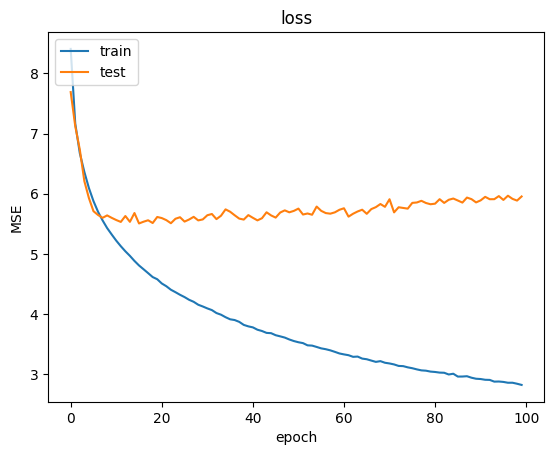

In [79]:
plt.plot(ret_para_hist.history['loss'])
plt.plot(ret_para_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','test'] , loc = "upper left")
plt.show()

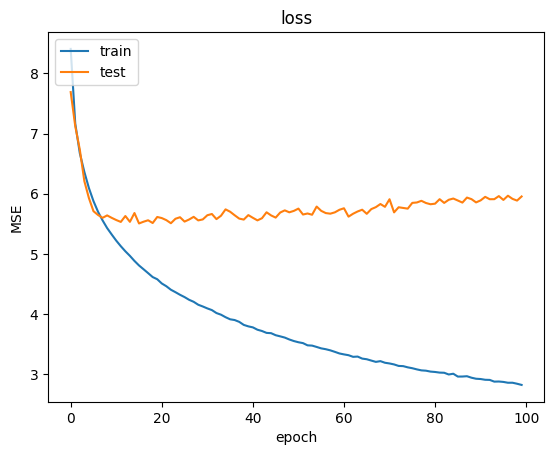

In [72]:
plt.plot(ret_para_hist.history['loss'])
plt.plot(ret_para_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','test'] , loc = "upper left")
plt.show()

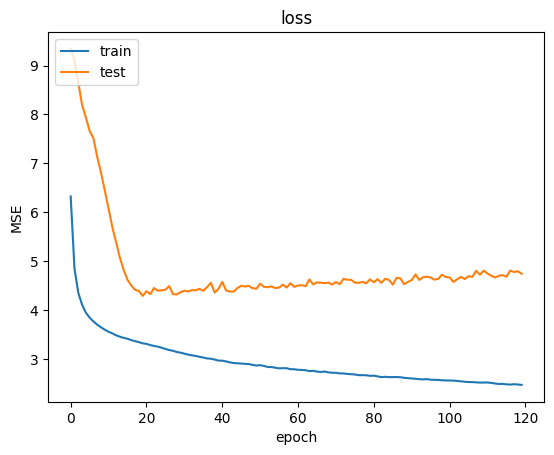

In [101]:
plt.plot(ret_para_Cap_hist.history['loss'])
plt.plot(ret_para_Cap_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','test'] , loc = "upper left")
plt.show()

TypeError: Image data of dtype object cannot be converted to float

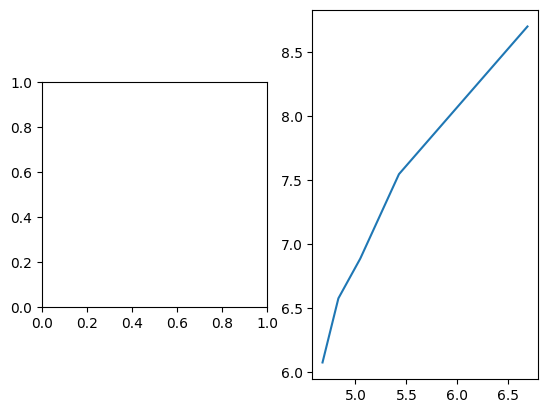

In [99]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(plt.plot(ret_para_hist.history['loss'], ret_para_hist.history['val_loss']))
axarr[1].imshow(image_datas[1])

In [41]:
train[1].shape

(4264, 1, 14, 11)

In [22]:
oag_kl_fcst_total

,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All
0,2021-05-06,180,609,156,468,186,810,1,3,1,5,170040,882900,156.0,643.0,368,1167,1.0,4.0,2,7,170040.0,1272030
1,2021-05-07,180,609,156,286,0,442,1,2,0,3,170040,481780,156.0,461.0,368,985,1.0,3.0,2,6,170040.0,1073650
2,2021-05-08,180,609,156,175,0,331,1,1,0,2,170040,360790,156.0,350.0,412,918,1.0,2.0,2,5,170040.0,1000620
3,2021-05-09,180,609,156,143,186,485,1,1,1,3,170040,528650,156.0,728.0,368,1252,1.0,5.0,2,8,170040.0,1364680
4,2021-05-10,180,609,156,143,0,299,1,1,0,2,170040,325910,156.0,572.0,368,1096,1.0,4.0,2,7,170040.0,1194640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2022-10-05,180,609,156,350,182,688,1,2,1,4,170040,749920,468.0,779.0,368,1615,3.0,5.0,2,10,510120.0,1760350
509,2022-10-06,180,609,156,532,182,870,1,3,1,5,170040,948300,468.0,961.0,182,1611,3.0,6.0,1,10,510120.0,1755990
510,2022-10-07,180,609,156,350,182,688,1,2,1,4,170040,749920,468.0,779.0,368,1615,3.0,5.0,2,10,510120.0,1760350
511,2022-10-08,180,609,156,143,182,481,1,1,1,3,170040,524290,468.0,493.0,368,1329,3.0,3.0,2,8,510120.0,1448610


In [23]:
oag_cap_kl

,dep_date,rpm,rev,pax,rasm,yield,load_fac,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst
0,2021-05-06,0.200692,0.064270,0.200692,0.075750,0.203741,0.358025,0.0,0.835476,0.451456,0.617896,0.0,1.0,0.5,0.6,0.0,0.617896
1,2021-05-07,0.224913,0.048722,0.224913,0.057424,0.137819,0.401235,0.0,0.367609,0.000000,0.172914,0.0,0.5,0.0,0.2,0.0,0.172914
2,2021-05-08,0.072664,0.031181,0.072664,0.036751,0.273006,0.129630,0.0,0.082262,0.000000,0.038694,0.0,0.0,0.0,0.0,0.0,0.038694
3,2021-05-09,0.543253,0.190634,0.543253,0.224683,0.223252,0.969136,0.0,0.000000,0.451456,0.224909,0.0,0.0,0.5,0.2,0.0,0.224909
4,2021-05-10,0.463668,0.156519,0.463668,0.184476,0.214763,0.827160,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2022-10-05,0.422145,0.209361,0.422145,0.246755,0.315523,0.753086,0.0,0.532134,0.441748,0.470375,0.0,0.5,0.5,0.4,0.0,0.470375
508,2022-10-06,0.307958,0.089676,0.307958,0.105694,0.185261,0.549383,0.0,1.000000,0.441748,0.690447,0.0,1.0,0.5,0.6,0.0,0.690447
509,2022-10-07,0.373702,0.162918,0.373702,0.192018,0.277359,0.666667,0.0,0.532134,0.441748,0.470375,0.0,0.5,0.5,0.4,0.0,0.470375
510,2022-10-08,0.363322,0.154380,0.363322,0.181954,0.270332,0.648148,0.0,0.000000,0.441748,0.220073,0.0,0.0,0.5,0.2,0.0,0.220073


In [18]:
df = pd.merge(df,oag_kl_fcst_total, left_on=['flightDepartureDate'],\
      right_on=['adj_dep_date'], how='left')

In [19]:
df

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All
0,2022-10-10,LAS,AUS,1,2021-06-06,7,M,Y,1,F,2021-06-06,0.06,0.06,0.06,0.16,0.36,0.48,0.790,0.850,0.98,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,22,0.073147,0.761012,0.809,0.098,0.493,0.409,0.591,0.405,0.931,1.000,2021-06-06,180.0,609.0,156.0,143.0,186.0,485.0,1.0,1.0,1.0,3.0,170040.0,528650.0,312.0,760.0,368.0,1440.0,2.0,5.0,2.0,9.0,340080.0,1569600.0
1,2022-10-10,LAS,AUS,1,2021-06-06,7,M,Y,2,F,2021-06-06,0.00,0.02,0.15,0.34,0.59,0.77,0.850,0.940,0.97,0.99,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,22,0.073147,0.761012,0.809,0.098,0.493,0.409,0.591,0.405,0.931,1.000,2021-06-06,180.0,609.0,156.0,143.0,186.0,485.0,1.0,1.0,1.0,3.0,170040.0,528650.0,312.0,760.0,368.0,1440.0,2.0,5.0,2.0,9.0,340080.0,1569600.0
2,2022-10-10,LAS,AUS,1,2021-06-06,7,M,Y,3,F,2021-06-06,0.00,0.04,0.18,0.38,0.62,0.71,0.870,0.930,0.97,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,22,0.073147,0.761012,0.809,0.098,0.493,0.409,0.591,0.405,0.931,1.000,2021-06-06,180.0,609.0,156.0,143.0,186.0,485.0,1.0,1.0,1.0,3.0,170040.0,528650.0,312.0,760.0,368.0,1440.0,2.0,5.0,2.0,9.0,340080.0,1569600.0
3,2022-10-10,LAS,AUS,1,2021-06-06,7,M,Y,4,F,2021-06-06,0.00,0.00,0.05,0.12,0.28,0.42,0.580,0.710,0.82,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,22,0.073147,0.761012,0.809,0.098,0.493,0.409,0.591,0.405,0.931,1.000,2021-06-06,180.0,609.0,156.0,143.0,186.0,485.0,1.0,1.0,1.0,3.0,170040.0,528650.0,312.0,760.0,368.0,1440.0,2.0,5.0,2.0,9.0,340080.0,1569600.0
4,2022-10-10,LAS,AUS,1,2021-06-06,7,M,Y,5,F,2021-06-06,0.00,0.00,0.00,0.00,0.01,0.04,0.070,0.110,0.43,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,22,0.073147,0.761012,0.809,0.098,0.493,0.409,0.591,0.405,0.931,1.000,2021-06-06,180.0,609.0,156.0,143.0,186.0,485.0,1.0,1.0,1.0,3.0,170040.0,528650.0,312.0,760.0,368.0,1440.0,2.0,5.0,2.0,9.0,340080.0,1569600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15124,2022-10-10,LAS,AUS,2,2022-05-28,6,M,Y,3,L,2022-05-28,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000,1.00,1.00,0.0,0.0,0.0,0.0,1.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0,0,0,0,21,0.107537,0.810277,0.381,0.000,0.209,0.147,0.624,0.000,0.005,0.012,2022-05-28,180.0,609.0,156.0,318.0,182.0,656.0,1.0,2.0,1.0,4.0,170040.0,715040.0,312.0,493.0,182.0,987.0,2.0,3.0,1.0,6.0,340080.0,1075830.0
15125,2022-10-10,LAS,AUS,2,2022-05-28,6,M,Y,4,L,2022-05-28,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.046,1.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,0.0,0.0

In [106]:
oag_kl =  oag_per_fcst(oag_df, fcst_start, fcst_end )
cap_kl = aa_cap_fcst(cap_df,fcst_start, fcst_end )
oag_cap_kl = merge_oag_aacap(oag_kl,cap_kl)
oag_cap_kl
    # merge OAG and AA Cap data

dep_date             0
seats                0
asm                  0
flt_ct               0
rpm                  0
                    ..
flt_ct_OA_fcst      16
flt_ct_ulcc_fcst    16
flt_ct_All_fcst     16
asm_AA_fcst         16
asm_All_fcst        16
Length: 22, dtype: int64


,dep_date,rpm,rev,pax,rasm,yield,load_fac,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst
0,2017-10-05,0.547945,0.534069,0.547945,0.534358,0.814680,0.548210,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,2017-10-15,0.232877,0.148596,0.232877,0.149124,0.319785,0.233327,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,2017-11-22,0.575342,0.515987,0.575342,0.516287,0.695203,0.575592,0.0,1.0,0.0,1.000000,0.0,1.0,0.0,1.0,0.0,1.000000
6,2017-12-18,0.246575,0.138244,0.246575,0.132237,0.202731,0.235869,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,2017-12-19,0.219178,0.157408,0.219178,0.157931,0.440234,0.219636,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,2019-03-17,0.986301,0.895482,0.986301,0.895546,0.709960,0.986309,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
53,2019-03-22,0.205479,0.119072,0.205479,0.119618,0.238119,0.205946,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
54,2019-03-24,0.945205,0.766355,0.945205,0.766500,0.559821,0.945238,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
55,2019-04-21,0.726027,0.467634,0.726027,0.467964,0.304699,0.726188,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [97]:
cap_k1 = aa_cap_fcst(cap_df,fcst_start, fcst_end )
cap_k1

,dep_date,seats,asm,flt_ct,rpm,rev,pax,rasm,yield,load_fac
0,2017-10-05,67,21976.0,1,13448.0,3509.51,41,0.159697,0.260969,0.611940
1,2017-10-15,67,21976.0,1,5904.0,1043.32,18,0.047475,0.176714,0.268657
2,2017-11-18,67,21976.0,1,3936.0,748.39,12,0.034055,0.190140,0.179104
3,2017-11-22,67,21976.0,1,14104.0,3393.82,43,0.154433,0.240628,0.641791
4,2017-11-23,67,21976.0,1,12792.0,2528.42,39,0.115054,0.197656,0.582090
...,...,...,...,...,...,...,...,...,...,...
52,2019-03-17,67,21976.0,1,23944.0,5821.76,73,0.264914,0.243141,1.089552
53,2019-03-22,67,21976.0,1,5248.0,854.43,16,0.038880,0.162811,0.238806
54,2019-03-24,67,21976.0,1,22960.0,4995.63,70,0.227322,0.217580,1.044776
55,2019-04-21,67,21976.0,1,17712.0,3084.47,54,0.140356,0.174146,0.805970


In [ ]:
 oag_kl_fcst_total